# Madness of March
## Jim Haines & Josh McCoy
### [Project Website](https://joshmccoy2.github.io/NCAA_March_Madness/)

## Collaboration Plan

For this project, we decided to setup a private Github repository to allow for collaboration. We worked together whenever possible, but we are also capabale of working independently of each other as long as we communicate and our work is well documented. We met multiple times a week to work on our project. We used libraries like matplotlib and seaborn and more (shown below) in our final tutorial to make meaningful visualizations. In all, we hope to be able to work with each other and outside sources to determine the best model to predict March Maddnes Tournament winners.

## Project overview and our goals

The main goal of our project is to outperform other competitors in the March Machine Learning Mania 2024 Kaggle competition. The goal of this competition is to create a model that can most accurately and confidently identify the winner of each game in the men's and women's NCAA basketball tournament. We also aim to eventually provide an interactive dashboard that will allow users to choose their own factors to see if they can outperform our design. This is a process that we would complete after participating in the competition.
 

We plan to use data from sources outside of just to improve our model past the given Kaggle data. We used a dataset consisting of KenPom ratings (explained further below) to ehance our dataset from Kaggle adn our chances in the competition.

We also plan to eventually add individual highschool player and ESPN ranking data data to further improve our model. This would allow us to include features like number of 4 and 5 star recruits on a team, or BPI (Basketball Power Index) ratings for a team, which are aggregation performance indicators, for example.

In the end, we plan to combine all of these datasets into our final model that will be selected based on our testing.

Since the data for the 2024 March Maddness competition has not yet been released, we are currently working with data from the 2022 competition. Although there are some changes from 2022 (Brier score, combining men's and women's competition) the data provided should be in a very similar format. Below we have included links to 3 previos competitions.

[2019 Competition](https://www.kaggle.com/competitions/mens-machine-learning-competition-2019)

[2021 Competition](https://www.kaggle.com/competitions/ncaam-march-mania-2021)

[2022 Competition](https://www.kaggle.com/competitions/mens-march-mania-2022)

## Current Datasets
[Kaggle datasets](https://www.kaggle.com/competitions/mens-march-mania-2022/data)

[KenPom Ratings](https://www.kaggle.com/code/verracodeguacas/kenneth-pomeroy-data-scraper-no-leakage/output)

# ETL & EDA

In [64]:
# Import necessary libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import xgboost as xgb
import requests
import numpy as np
import csv
import re
import time
import Levenshtein 
from io import StringIO
from io import StringIO
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import brier_score_loss, accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error, r2_score, roc_curve, auc, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from scipy.special import expit 
from scipy.special import expit  # Import the sigmoid function
from xgboost import XGBClassifier
from bs4 import BeautifulSoup
from fuzzywuzzy import process

We can first look at how some basic factors affect the amount the winning team wins by. We want to look at the difference in score to see how dominant a team is against a competitor. A team who wins by a lot is typically a sign that this team is significantly better than its oponent.

In [65]:
# To do this we can look at regular season game stats
detailed_results_data = 'MRegularSeasonDetailedResults.csv'
detailed_results = pd.read_csv(detailed_results_data)
detailed_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100418,2022,98,1400,79,1242,76,H,0,28,67,...,13,15,23,5,24,10,15,3,5,21
100419,2022,98,1411,66,1126,63,A,0,24,59,...,21,15,24,5,23,10,19,13,2,23
100420,2022,98,1422,68,1441,49,A,0,23,56,...,24,8,11,10,18,5,16,8,2,12
100421,2022,98,1438,69,1181,68,A,0,31,65,...,17,18,22,11,25,14,14,3,9,11



Let's check the datatypes

In [66]:
detailed_results.dtypes

Season      int64
DayNum      int64
WTeamID     int64
WScore      int64
LTeamID     int64
LScore      int64
WLoc       object
NumOT       int64
WFGM        int64
WFGA        int64
WFGM3       int64
WFGA3       int64
WFTM        int64
WFTA        int64
WOR         int64
WDR         int64
WAst        int64
WTO         int64
WStl        int64
WBlk        int64
WPF         int64
LFGM        int64
LFGA        int64
LFGM3       int64
LFGA3       int64
LFTM        int64
LFTA        int64
LOR         int64
LDR         int64
LAst        int64
LTO         int64
LStl        int64
LBlk        int64
LPF         int64
dtype: object

All the dtypes look correct, so lets move on to our analysis

In [67]:
# Create variable for amount by which winning team wins
detailed_results['SCOREDIFF'] = detailed_results['WScore'] - detailed_results['LScore']

When you see W or L this stands for Winning or Losing team.

In [68]:
# Winner stats
detailed_results.dtypes
detailed_results['WFGPCT'] = detailed_results['WFGM']/detailed_results['WFGA']       # field goal pt completion %
detailed_results['W3PCT'] = detailed_results['WFGM3']/detailed_results['WFGA3']      # 3 pt completion %
detailed_results['WFTPCT'] = detailed_results['WFTM']/detailed_results['WFTA']       # free throw completion %
detailed_results['WORBCHANCE'] =  detailed_results['WOR'] + detailed_results['LDR']  # total potential rebounds
detailed_results['WORPCT'] = detailed_results['WOR']/detailed_results['WORBCHANCE']  # rebound completion %

In [69]:
# Losing stats
detailed_results['LFGPCT'] = detailed_results['LFGM']/detailed_results['LFGA']       
detailed_results['L3PCT'] = detailed_results['LFGM3']/detailed_results['LFGA3']
detailed_results['LFTPCT'] = detailed_results['LFTM']/detailed_results['LFTA']
detailed_results['LORBCHANCE'] =  detailed_results['LOR'] + detailed_results['WDR']
detailed_results['LORPCT'] = detailed_results['LOR']/detailed_results['LORBCHANCE']

We can now take a more detailed look at the correlation between winner field goal % and score difference.

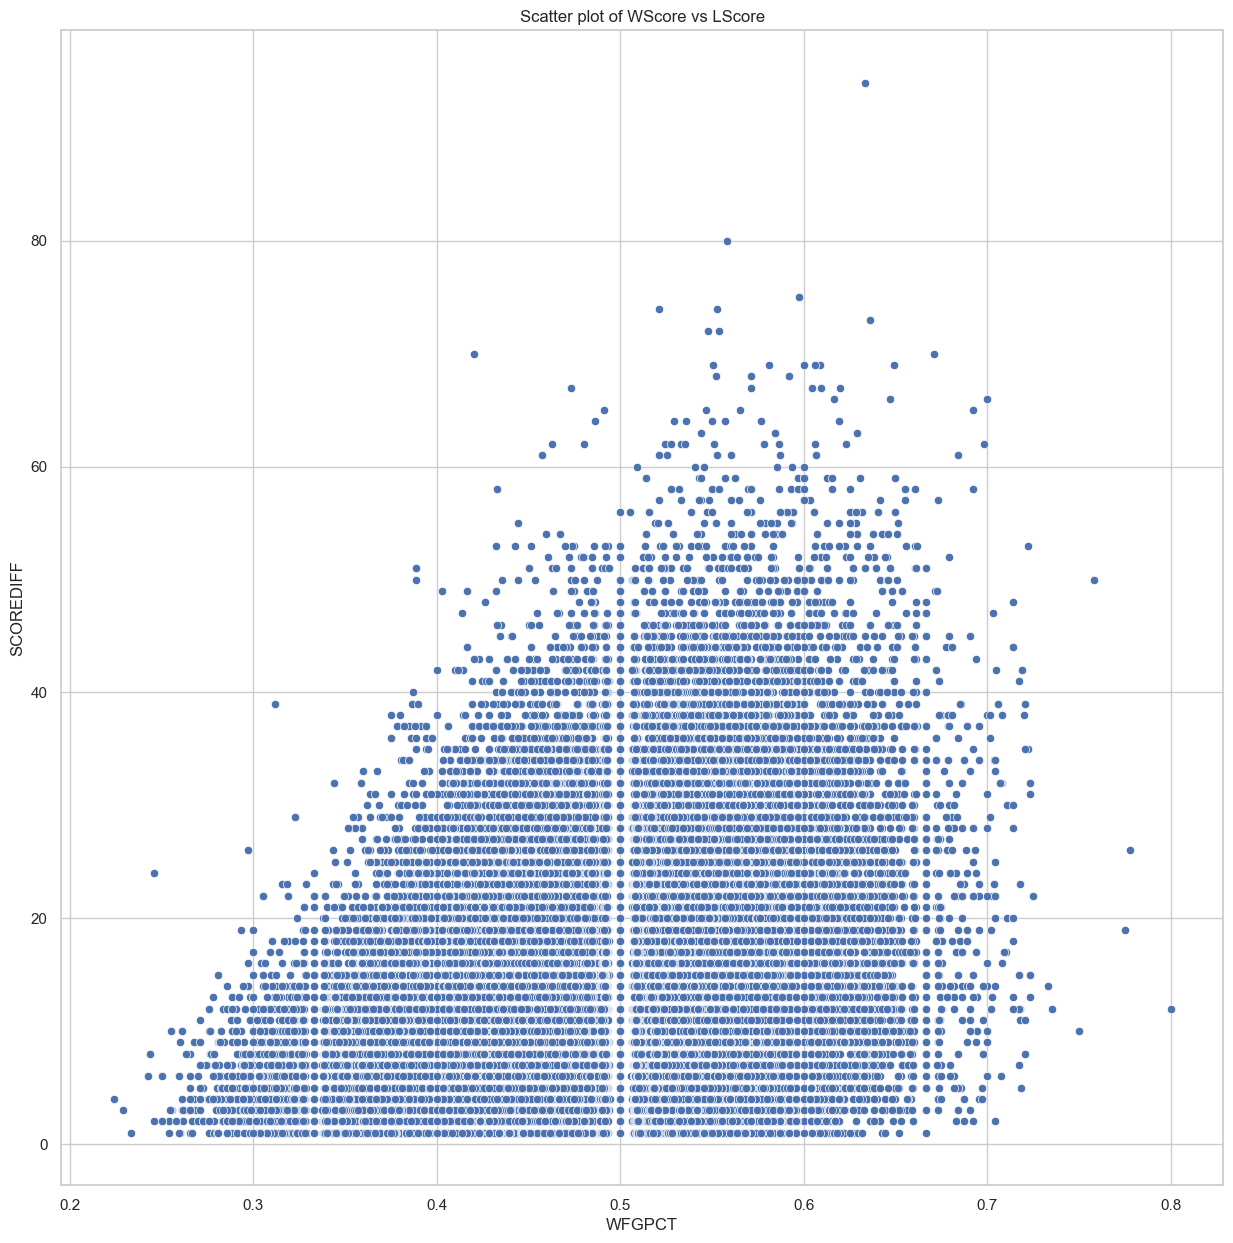

In [70]:
plt.figure(figsize=(15,15))
sns.scatterplot(x='WFGPCT', y='SCOREDIFF', data=detailed_results)
plt.title('Scatter plot of WScore vs LScore')
plt.xlabel('WFGPCT')
plt.ylabel('SCOREDIFF')
plt.show()

We can look at other factors as well:

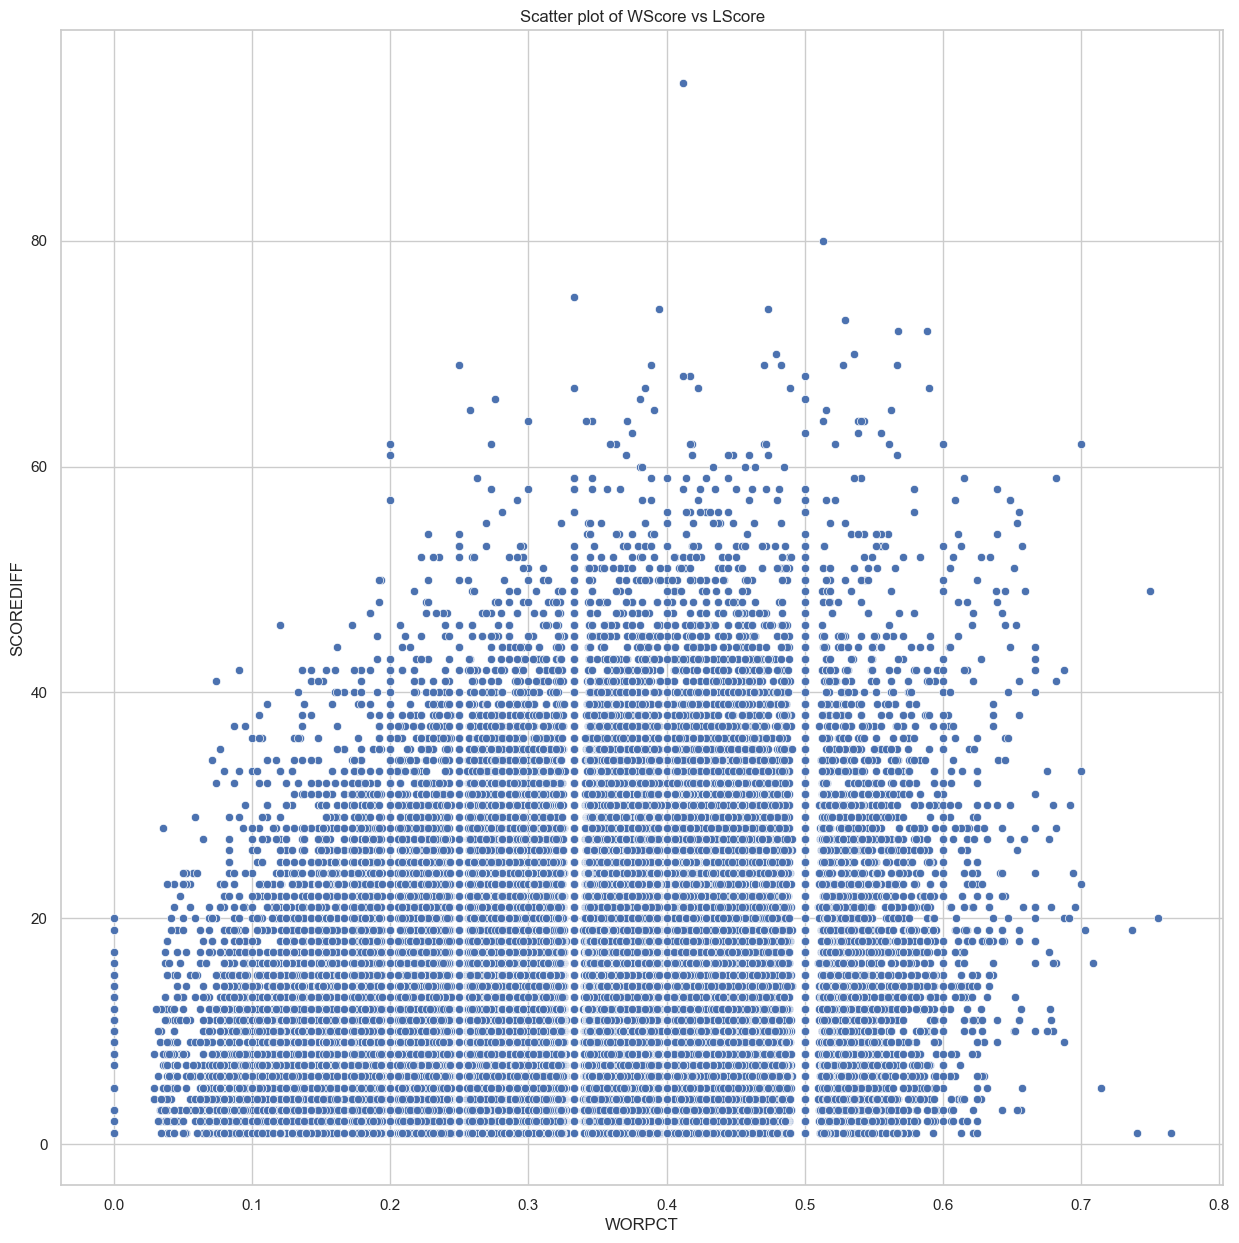

In [71]:
plt.figure(figsize=(15,15))
sns.scatterplot(x='WORPCT', y='SCOREDIFF', data=detailed_results)
plt.title('Scatter plot of WScore vs LScore')
plt.xlabel('WORPCT')
plt.ylabel('SCOREDIFF')
plt.show()

Despite the common phrase "board man gets paid", we can see that there is a less strong correlation between offensive rebound % and score difference. Perhaps this saying holds more true a higher level of play.

We can also take a look at detailed results from the actual tournament to see if there are any obvious differences from the regular season data. To do this we can replicate the above regular season analysis.

In [72]:
detailed_tourney_data = 'MNCAATourneyDetailedResults.csv'
detailed_tourney_results = pd.read_csv(detailed_tourney_data)
detailed_tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,2021,148,1211,85,1425,66,N,0,33,66,...,15,14,19,7,20,9,9,7,0,13
1177,2021,148,1417,51,1276,49,N,0,21,54,...,11,6,11,8,24,12,14,5,3,11
1178,2021,152,1124,78,1222,59,N,0,29,55,...,19,11,16,13,12,10,10,4,5,10
1179,2021,152,1211,93,1417,90,N,1,37,63,...,17,14,21,7,24,21,9,4,1,16


In [73]:
detailed_tourney_results.dtypes

Season      int64
DayNum      int64
WTeamID     int64
WScore      int64
LTeamID     int64
LScore      int64
WLoc       object
NumOT       int64
WFGM        int64
WFGA        int64
WFGM3       int64
WFGA3       int64
WFTM        int64
WFTA        int64
WOR         int64
WDR         int64
WAst        int64
WTO         int64
WStl        int64
WBlk        int64
WPF         int64
LFGM        int64
LFGA        int64
LFGM3       int64
LFGA3       int64
LFTM        int64
LFTA        int64
LOR         int64
LDR         int64
LAst        int64
LTO         int64
LStl        int64
LBlk        int64
LPF         int64
dtype: object

In [74]:
# Create variable for amount by which winning team wins
detailed_tourney_results['SCOREDIFF'] = detailed_tourney_results['WScore'] - detailed_tourney_results['LScore']

In [75]:
# Winner stats
detailed_tourney_results.dtypes
detailed_tourney_results['WFGPCT'] = detailed_tourney_results['WFGM']/detailed_tourney_results['WFGA']       # field goal pt completion %
detailed_tourney_results['W3PCT'] = detailed_tourney_results['WFGM3']/detailed_tourney_results['WFGA3']      # 3 pt completion %
detailed_tourney_results['WFTPCT'] = detailed_tourney_results['WFTM']/detailed_tourney_results['WFTA']       # free throw completion %
detailed_tourney_results['WORBCHANCE'] =  detailed_tourney_results['WOR'] + detailed_tourney_results['LDR']  # total potential rebounds
detailed_tourney_results['WORPCT'] = detailed_tourney_results['WOR']/detailed_tourney_results['WORBCHANCE']  # rebound completion %

In [76]:
# Losing stats
detailed_tourney_results['LFGPCT'] = detailed_tourney_results['LFGM']/detailed_tourney_results['LFGA']       
detailed_tourney_results['L3PCT'] = detailed_tourney_results['LFGM3']/detailed_tourney_results['LFGA3']
detailed_tourney_results['LFTPCT'] = detailed_tourney_results['LFTM']/detailed_tourney_results['LFTA']
detailed_tourney_results['LORBCHANCE'] =  detailed_tourney_results['LOR'] + detailed_tourney_results['WDR']
detailed_tourney_results['LORPCT'] = detailed_tourney_results['LOR']/detailed_tourney_results['LORBCHANCE']

In [77]:
detailed_tourney_results.dtypes

Season          int64
DayNum          int64
WTeamID         int64
WScore          int64
LTeamID         int64
LScore          int64
WLoc           object
NumOT           int64
WFGM            int64
WFGA            int64
WFGM3           int64
WFGA3           int64
WFTM            int64
WFTA            int64
WOR             int64
WDR             int64
WAst            int64
WTO             int64
WStl            int64
WBlk            int64
WPF             int64
LFGM            int64
LFGA            int64
LFGM3           int64
LFGA3           int64
LFTM            int64
LFTA            int64
LOR             int64
LDR             int64
LAst            int64
LTO             int64
LStl            int64
LBlk            int64
LPF             int64
SCOREDIFF       int64
WFGPCT        float64
W3PCT         float64
WFTPCT        float64
WORBCHANCE      int64
WORPCT        float64
LFGPCT        float64
L3PCT         float64
LFTPCT        float64
LORBCHANCE      int64
LORPCT        float64
dtype: obj

In [78]:
detailed_tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,WFGPCT,W3PCT,WFTPCT,WORBCHANCE,WORPCT,LFGPCT,L3PCT,LFTPCT,LORBCHANCE,LORPCT
0,2003,134,1421,92,1411,84,N,1,32,69,...,0.463768,0.379310,0.653846,42,0.333333,0.432836,0.387097,0.451613,47,0.361702
1,2003,136,1112,80,1436,51,N,0,31,66,...,0.469697,0.304348,0.785714,37,0.297297,0.312500,0.250000,1.000000,44,0.181818
2,2003,136,1113,84,1272,71,N,0,31,59,...,0.525424,0.428571,0.727273,32,0.312500,0.362319,0.250000,0.666667,47,0.425532
3,2003,136,1141,79,1166,73,N,0,29,53,...,0.547170,0.428571,0.720000,28,0.392857,0.450000,0.411765,0.705882,34,0.411765
4,2003,136,1143,76,1301,74,N,1,27,64,...,0.421875,0.350000,0.652174,44,0.409091,0.446429,0.428571,0.750000,30,0.333333


# Creating Dataframe for Model Testing

First, we want to format a dataframe that we can use from Kaggle. To do this, we took the above `detailed_tourney_results` df and split it up so that each row is a team, and we added an outcome variable indicating a win or loss. This will allow us to predict an outcome per team, which is what we will ultimately be doing to the competition.

In [79]:
# Create a new data frame for winning teams
df_winning = detailed_tourney_results[['Season', 'DayNum', 'NumOT', 'SCOREDIFF'] + [col for col in detailed_tourney_results.columns if col.startswith('W')]].copy()
df_winning['Outcome'] = 1
df_winning['Outcome'] = df_winning['Outcome'].astype(int)


# Create a new data frame for losing teams
df_losing = detailed_tourney_results[['Season', 'DayNum', 'NumOT', 'SCOREDIFF'] + [col for col in detailed_tourney_results.columns if col.startswith('L')]].copy()
df_losing['Outcome'] = 0
df_losing['Outcome'] = df_losing['Outcome'].astype(int)

In [80]:
# Remove the 'W' or 'L' prefix from the column names
df_winning.columns = [col[1:] if col.startswith('W') else col for col in df_winning.columns]
df_losing.columns = [col[1:] if col.startswith('L') else col for col in df_losing.columns]
# Combine the two DataFrames
combined_df = pd.concat([df_winning, df_losing], ignore_index=True)
combined_df

,Season,DayNum,NumOT,SCOREDIFF,TeamID,Score,Loc,FGM,FGA,FGM3,...,TO,Stl,Blk,PF,FGPCT,3PCT,FTPCT,ORBCHANCE,ORPCT,Outcome
0,2003,134,1,8,1421,92,N,32,69,11,...,12,5,3,22,0.463768,0.379310,0.653846,42,0.333333,1
1,2003,136,0,29,1112,80,N,31,66,7,...,16,10,7,8,0.469697,0.304348,0.785714,37,0.297297,1
2,2003,136,0,13,1113,84,N,31,59,6,...,9,7,4,19,0.525424,0.428571,0.727273,32,0.312500,1
3,2003,136,0,6,1141,79,N,29,53,3,...,18,13,1,19,0.547170,0.428571,0.720000,28,0.392857,1
4,2003,136,1,2,1143,76,N,27,64,7,...,13,8,2,14,0.421875,0.350000,0.652174,44,0.409091,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2357,2021,148,0,19,1425,66,NaN,24,62,4,...,9,7,0,13,0.387097,0.266667,0.736842,34,0.205882,0
2358,2021,148,0,2,1276,49,NaN,20,51,3,...,14,5,3,11,0.392157,0.272727,0.545455,29,0.275862,0
2359,2021,152,0,19,1222,59,NaN,21,55,6,...,10,4,5,10,0.381818,0.315789,0.687500,30,0.433333,0
2360,2021,152,1,3,1417,90,NaN,34,59,8,...,9,4,1,16,0.576271,0.470588,0.666667,26,0.269231,0


Here, we are using MTeams to match team names to our prevoius dataframe with more detailed stats

In [81]:
mteams_df = pd.read_csv('MTeams.csv')

# Merge on 'TeamID'
combined_df = pd.merge(combined_df, mteams_df[['TeamID', 'TeamName']], on='TeamID', how='left')

combined_df.head()

,Season,DayNum,NumOT,SCOREDIFF,TeamID,Score,Loc,FGM,FGA,FGM3,...,Stl,Blk,PF,FGPCT,3PCT,FTPCT,ORBCHANCE,ORPCT,Outcome,TeamName
0,2003,134,1,8,1421,92,N,32,69,11,...,5,3,22,0.463768,0.379310,0.653846,42,0.333333,1,UNC Asheville
1,2003,136,0,29,1112,80,N,31,66,7,...,10,7,8,0.469697,0.304348,0.785714,37,0.297297,1,Arizona
2,2003,136,0,13,1113,84,N,31,59,6,...,7,4,19,0.525424,0.428571,0.727273,32,0.312500,1,Arizona St
3,2003,136,0,6,1141,79,N,29,53,3,...,13,1,19,0.547170,0.428571,0.720000,28,0.392857,1,C Michigan
4,2003,136,1,2,1143,76,N,27,64,7,...,8,2,14,0.421875,0.350000,0.652174,44,0.409091,1,California


In [82]:
# Reorganize column order

combined_df = combined_df[['TeamName', 'Season', 'Outcome', 'TeamID', 'DayNum', 'NumOT', 'Score', 'SCOREDIFF', 
                          'FGM', 'FGA', 'FGPCT', 'FGM3', 'FGA3', '3PCT', 'FTM', 'FTA', 'FTPCT', 'OR', 'DR', 
                          'ORBCHANCE', 'ORPCT', 'Ast', 'Stl', 'Blk', 'TO', 'PF']]

combined_df.columns

Index(['TeamName', 'Season', 'Outcome', 'TeamID', 'DayNum', 'NumOT', 'Score',
       'SCOREDIFF', 'FGM', 'FGA', 'FGPCT', 'FGM3', 'FGA3', '3PCT', 'FTM',
       'FTA', 'FTPCT', 'OR', 'DR', 'ORBCHANCE', 'ORPCT', 'Ast', 'Stl', 'Blk',
       'TO', 'PF'],
      dtype='object')

In [83]:
combined_df

,TeamName,Season,Outcome,TeamID,DayNum,NumOT,Score,SCOREDIFF,FGM,FGA,...,FTPCT,OR,DR,ORBCHANCE,ORPCT,Ast,Stl,Blk,TO,PF
0,UNC Asheville,2003,1,1421,134,1,92,8,32,69,...,0.653846,14,30,42,0.333333,17,5,3,12,22
1,Arizona,2003,1,1112,136,0,80,29,31,66,...,0.785714,11,36,37,0.297297,22,10,7,16,8
2,Arizona St,2003,1,1113,136,0,84,13,31,59,...,0.727273,10,27,32,0.312500,18,7,4,9,19
3,C Michigan,2003,1,1141,136,0,79,6,29,53,...,0.720000,11,20,28,0.392857,15,13,1,18,19
4,California,2003,1,1143,136,1,76,2,27,64,...,0.652174,18,20,44,0.409091,17,8,2,13,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2357,USC,2021,0,1425,148,0,66,19,24,62,...,0.736842,7,20,34,0.205882,9,7,0,9,13
2358,Michigan,2021,0,1276,148,0,49,2,20,51,...,0.545455,8,24,29,0.275862,12,5,3,14,11
2359,Houston,2021,0,1222,152,0,59,19,21,55,...,0.687500,13,12,30,0.433333,10,4,5,10,10
2360,UCLA,2021,0,1417,152,1,90,3,34,59,...,0.666667,7,24,26,0.269231,21,4,1,9,16


In [84]:
# Select rows where season is 2003 and DayNum is 134 as a test
selected_rows = combined_df[(combined_df['Season'] == 2003) & (combined_df['DayNum'] == 134)]
selected_rows

,TeamName,Season,Outcome,TeamID,DayNum,NumOT,Score,SCOREDIFF,FGM,FGA,...,FTPCT,OR,DR,ORBCHANCE,ORPCT,Ast,Stl,Blk,TO,PF
0,UNC Asheville,2003,1,1421,134,1,92,8,32,69,...,0.653846,14,30,42,0.333333,17,5,3,12,22
1181,TX Southern,2003,0,1411,134,1,84,8,29,67,...,0.451613,17,28,47,0.361702,16,5,0,15,22


## Ken Pomeroy Rankings

The dataset we want to combine with our Kaggle dataset is one containing Ken Pomery rankings (KenPom ratings). This dataset includes the following features:

- adj_o (adjusted offensive efficiency): This is a measure of how many points a team scores per 100 possessions.
- adj_d (adjusted defensive efficiency): This is a measure of how many points a team allows per 100 possessions.
- sos_adj_o: This is a measure of how difficult a team’s schedule has been offensively.
- sos_adj_d: This is a measure of how difficult a team’s schedule has been defensively.
- adj_tempo: amount of possessions that a team has per 40 minutes (over the course of one game).
- luck: the deviation between a team's actual winning percentage and the expected from the previous metrics.

We think that these aggregate features can help our model past just the information the Kaggle datasets

In [85]:
Pomeroy_data = 'kenpom_2023.csv'
pomeroy_df = pd.read_csv(Pomeroy_data)
pomeroy_df = pomeroy_df.drop("Unnamed: 0", axis=1)

# Display df
pomeroy_df.head()

,Season,TeamName,adj_o,adj_d,adj_tempo,luck,sos_adj_o,sos_adj_d
0,2011,Ohio St.,125.4,88.4,66.0,0.043,107.4,98.3
1,2011,Duke,118.8,87.2,70.1,0.006,106.0,97.4
2,2011,Kansas,119.8,88.3,69.6,0.071,106.1,98.7
3,2011,Texas,114.0,85.3,67.2,-0.055,105.6,97.8
4,2011,Purdue,116.1,87.2,67.1,-0.004,108.1,97.3


## KenPom EDA

In [86]:
print(pomeroy_df.info())
print(pomeroy_df.describe())
print(pomeroy_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4223 entries, 0 to 4222
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Season     4223 non-null   int64  
 1   TeamName   4223 non-null   object 
 2   adj_o      4223 non-null   float64
 3   adj_d      4223 non-null   float64
 4   adj_tempo  4223 non-null   float64
 5   luck       4223 non-null   float64
 6   sos_adj_o  4223 non-null   float64
 7   sos_adj_d  4223 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 264.1+ KB
None
            Season        adj_o        adj_d    adj_tempo         luck  \
count  4223.000000  4223.000000  4223.000000  4223.000000  4223.000000   
mean   2016.802036   103.152617   103.250722    67.134880     0.001466   
std       3.796034     7.405705     6.612828     2.961769     0.053758   
min    2011.000000    73.400000    81.000000    57.600000    -0.192000   
25%    2014.000000    98.200000    98.700000    65.2000

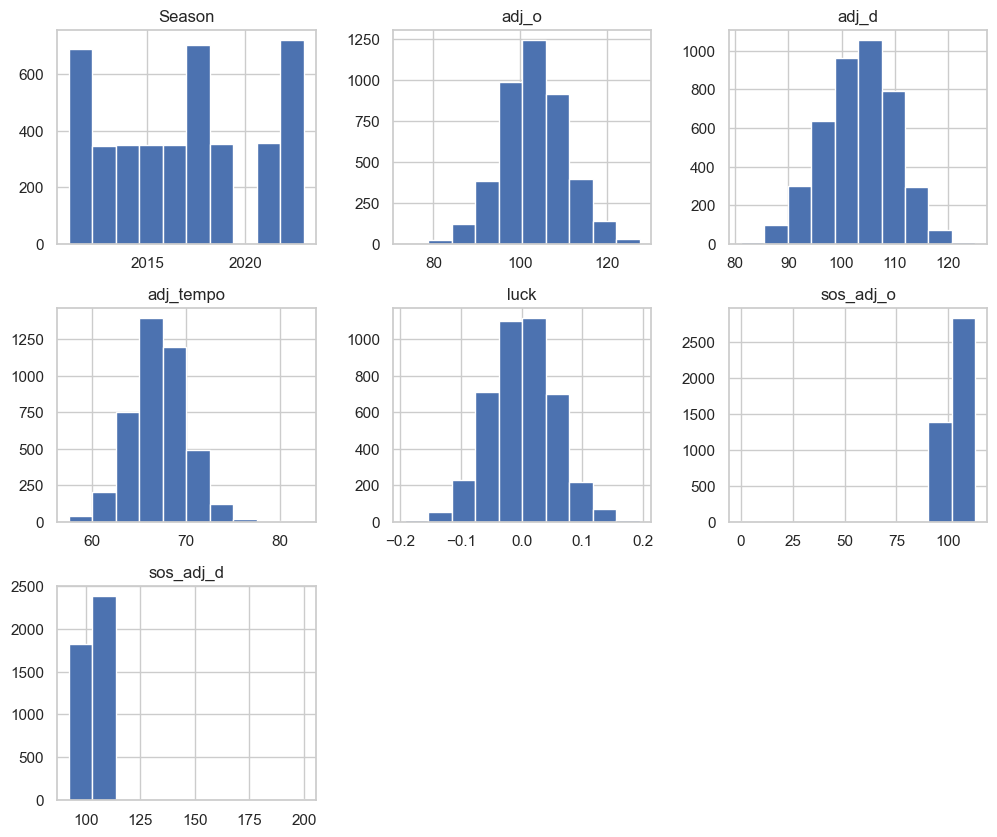

In [87]:
# Distribution of each feature included over time

pomeroy_df.hist(figsize=(12, 10))
plt.show()

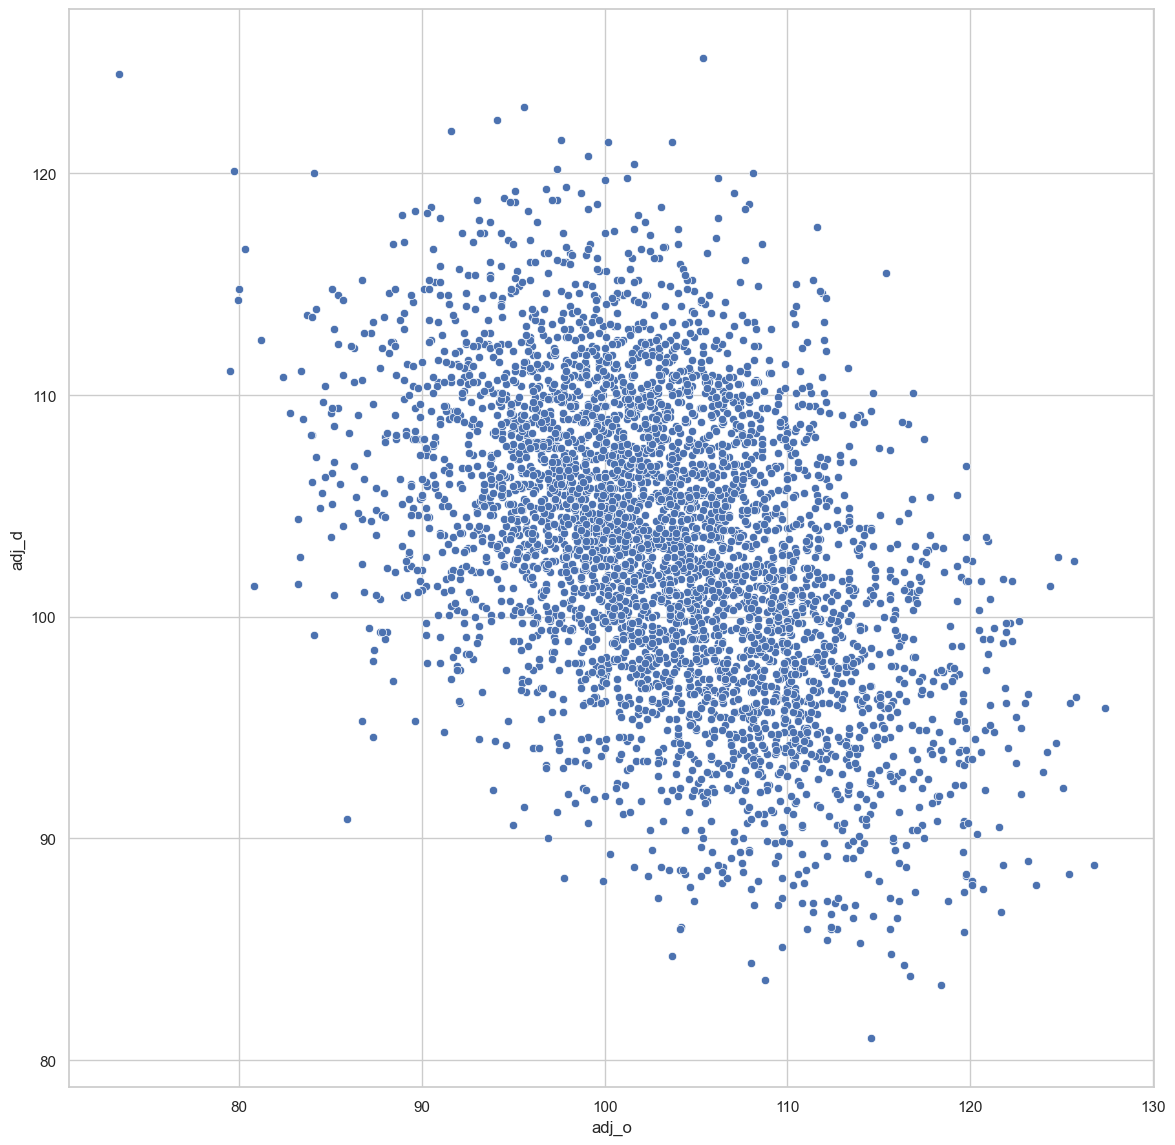

In [88]:
# Adjusted offensive and defensive efficiencies

plt.figure(figsize=(14, 14))
sns.scatterplot(data=pomeroy_df, x='adj_o', y='adj_d')
plt.show()

We can see a pretty normal distribution from this including some outliers, like the team that scored less than 80 points and allowed over 120 per 100 possesions.

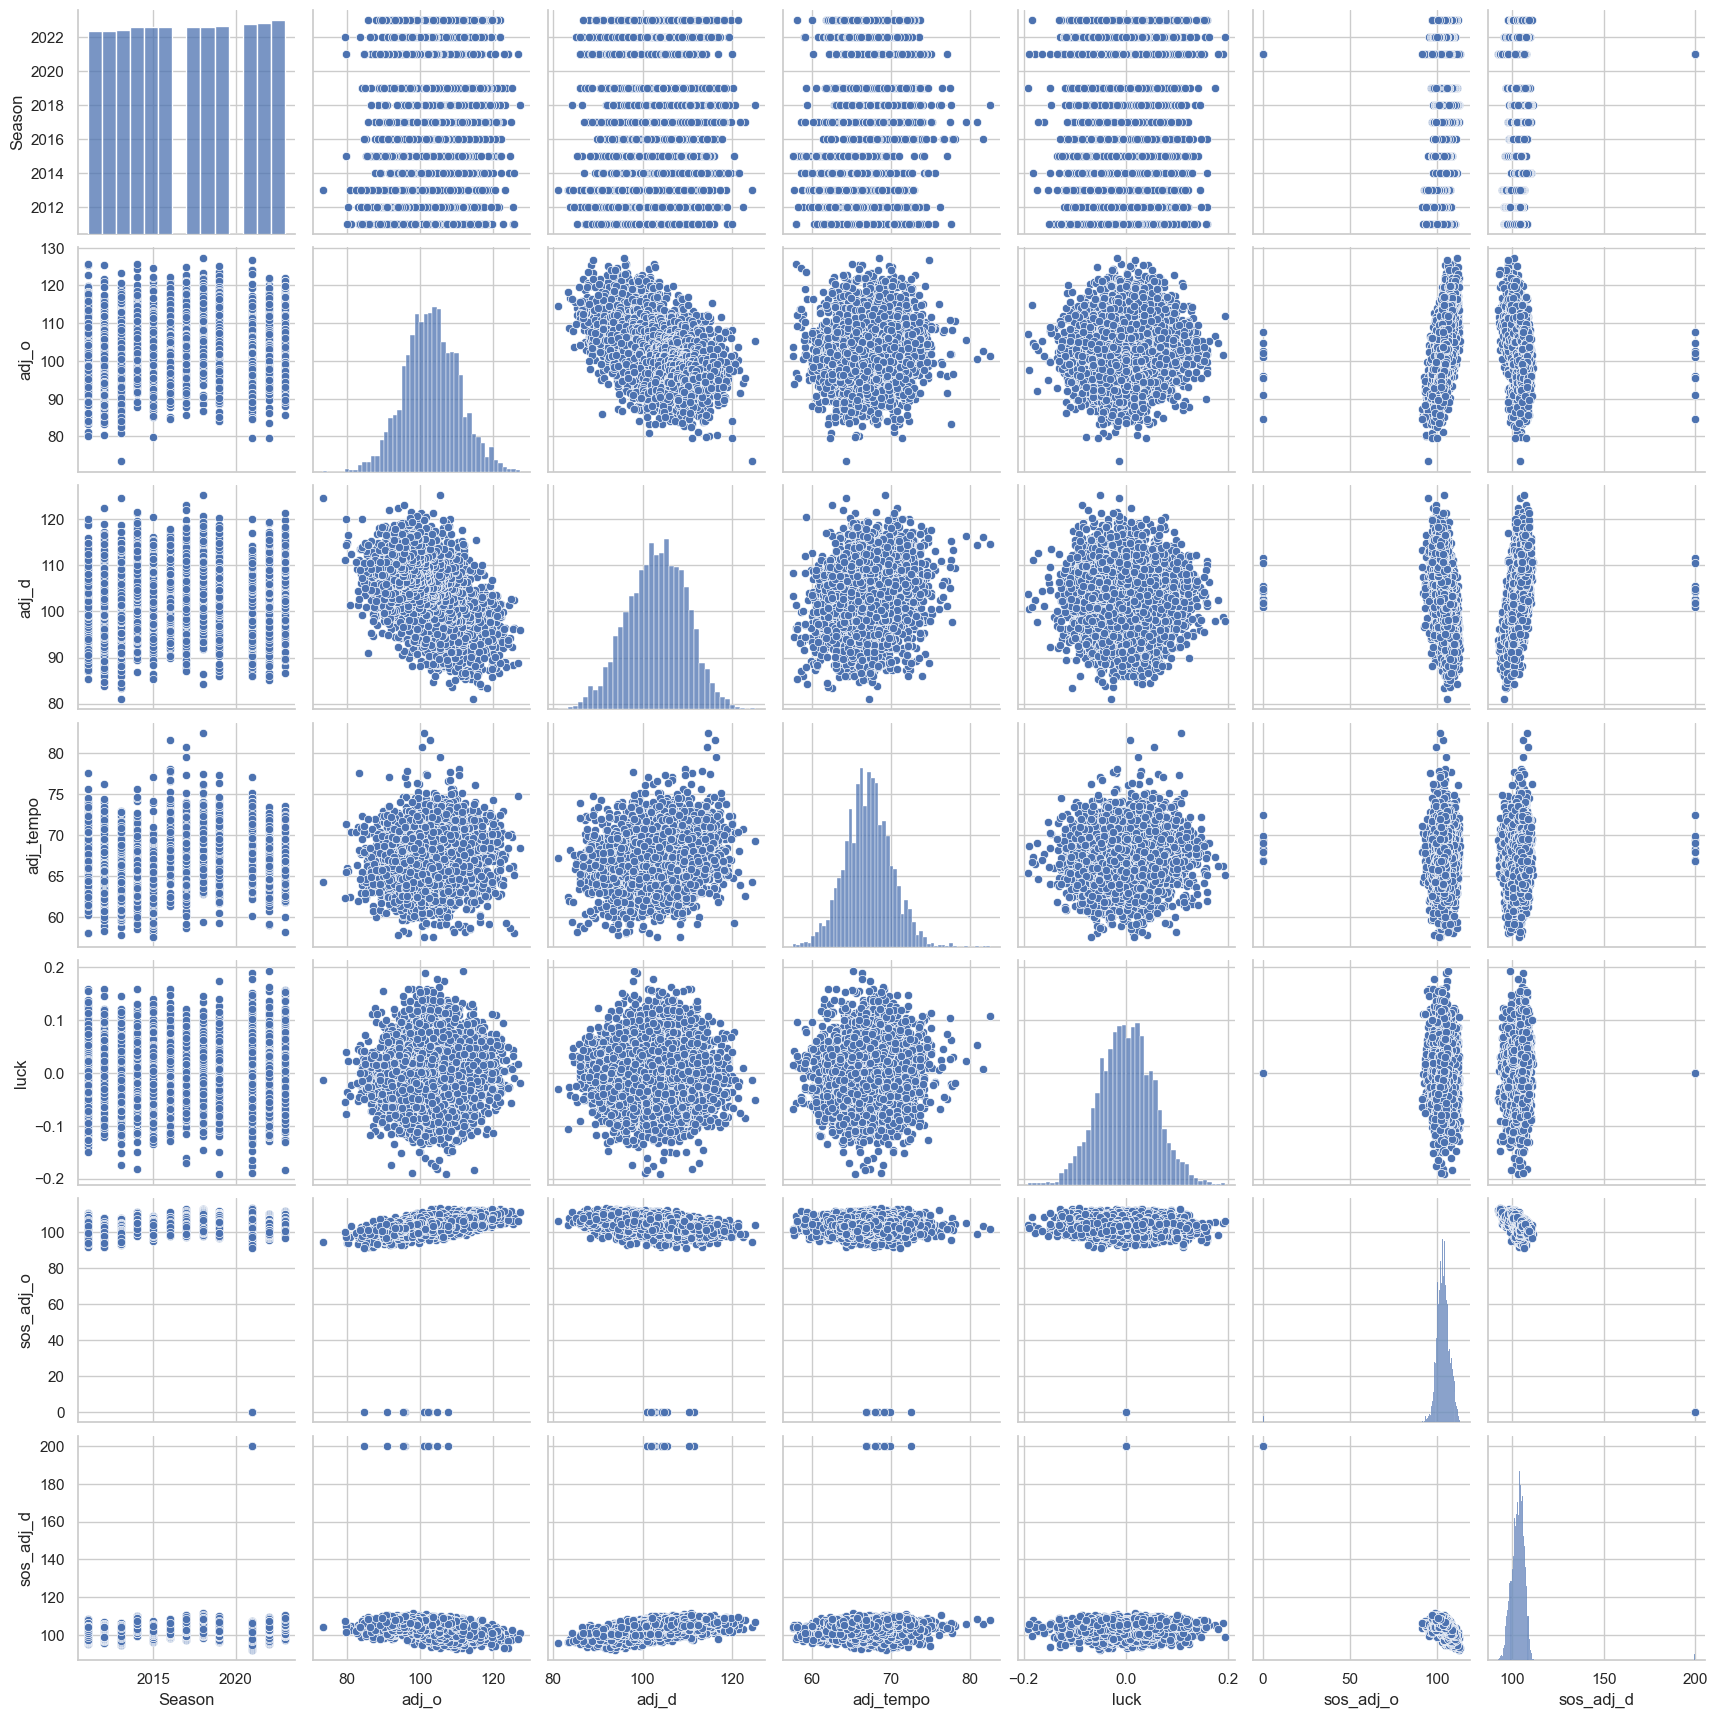

In [89]:
# A pairplot will allow us to see how different features interact.

sns.pairplot(pomeroy_df)
plt.show()

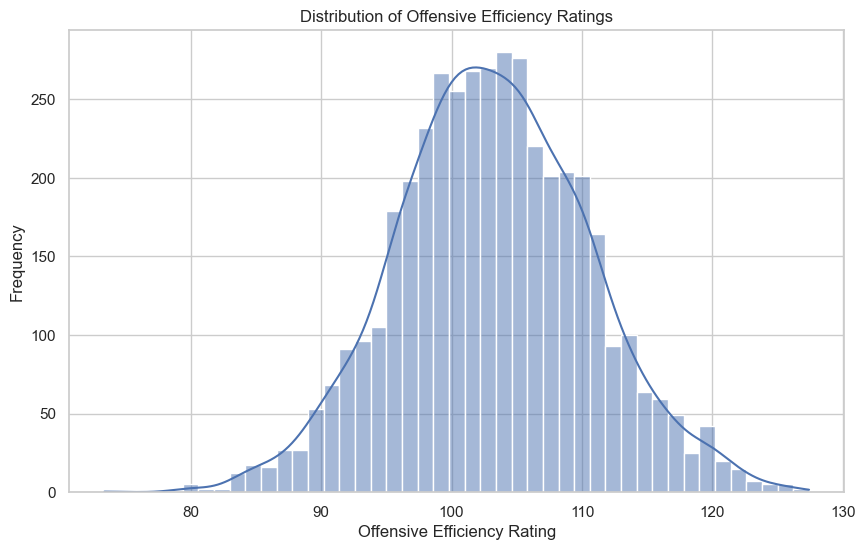

In [90]:
# A more detailed look at offensive efficiency distribution. Normal as we would expect.

sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(pomeroy_df['adj_o'], kde=True)

plt.title('Distribution of Offensive Efficiency Ratings')
plt.xlabel('Offensive Efficiency Rating')
plt.ylabel('Frequency')

plt.show()

# ESPN BPI Data

Next, we have a dataset from ESPN that contains a BPI rating for each team. BPI is defined by ESPN: “Basketball Power Index (BPI) measures a team’s true strength going forward; expected point margin per 70 possessions vs an average opponent on a neutral court.” This measure is especially useful because we understand how the measurement was taken, and we have been interested in incorporating a margin of victory measure into our model. Below is an image that shows average BPI by conference.

The BPI evaluates the overall strength of basketball teams, introduced in 2012 for college basketball. The BPI uses a complex algorithm that includes various components to generate a numerical rating for each team.

Key factors considered in the calculation are:

Strength of Record: This looks at the difficulty of a team's wins and losses based on their opponents.
Game-by-Game Efficiency: Measures the efficiency of a team’s offense and defense in individual games.
Luck: Assesses a team's luck based on the number of close games won or lost.
Other Factors: Includes the impact of home-court advantage, location, and travel.

In [91]:
espn_bpi_df = 'ESPN_BPI.csv'
espn_bpi_df = pd.read_csv(espn_bpi_df)
espn_bpi_df

,Rk,Team,Conf,W-L,BPI Off,BPI Def,BPI,Year
0,1,Kansas,Big 12,37-3,12.4,9.6,21.9,2008
1,2,North Carolina,ACC,36-3,19.2,1.0,20.2,2008
2,3,Memphis,C-USA,38-2,11.3,8.0,19.3,2008
3,4,UCLA,Pac-12,35-4,7.9,10.9,18.9,2008
4,5,Duke,ACC,28-6,13.8,4.3,18.2,2008
...,...,...,...,...,...,...,...,...
3814,347,Mississippi Valley St.,SWAC,28-Apr,-9.9,-6.5,-16.3,2018
3815,348,Chicago St.,WAC,29-Mar,-7.5,-9.0,-16.5,2018
3816,349,Delaware St.,MEAC,28-Apr,-9.4,-8.5,-18.0,2018
3817,350,Alabama A&M,SWAC,28-Mar,-11.7,-7.4,-19.1,2018


In [92]:
files_and_years = {
    'ESPN2023.csv': 2023,
    'ESPN 2022.csv': 2022,
    'ESPN 2021.csv': 2021,
    'ESPN2019.csv': 2019
}

# Iterate over the files and append them to your DataFrame
for file, year in files_and_years.items():
    # Read the CSV file
    temp_df = pd.read_csv(file)
    
    # Add a 'Year' column
    temp_df['Year'] = year
    
    # Drop rows with NaN values in the 'Year' column
    temp_df = temp_df.dropna(subset=['Year'])
    
    # Drop rows where 'Rk' (rank) is NaN
    temp_df = temp_df.dropna(subset=['BPI RK'])
    
    # Rename columns
    temp_df = temp_df.rename(columns={
        'BPI RK': 'Rk',
        'TEAM': 'Team',
        'CONF': 'Conf',
        'W-L': 'W-L',
        'BPI': 'BPI',
        'OFF': 'BPI Off',
        'DEF': 'BPI Def',
        'Year': 'Year'
    })
    
    # Drop all columns with NaN values
    temp_df = temp_df.dropna(axis=1, how='all')
    
    # Concatenate with the existing DataFrame
    espn_bpi_df = pd.concat([espn_bpi_df, temp_df], ignore_index=True)

# Sort the DataFrame by 'Year'
espn_bpi_df = espn_bpi_df.sort_values(by='Year')

# Reset the index
espn_bpi_df.reset_index(drop=True, inplace=True)

# Print the transformed and concatenated DataFrame
espn_bpi_df

,Rk,Team,Conf,W-L,BPI Off,BPI Def,BPI,Year
0,1.0,Kansas,Big 12,37-3,12.4,9.6,21.9,2008
1,232.0,Montana St.,Big Sky,15-15,0.7,-4.8,-4.1,2008
2,231.0,McNeese St.,Southland,13-16,-5.7,1.6,-4.1,2008
3,230.0,UL Monroe,Sun Belt,21-Oct,-0.1,-4.0,-4.1,2008
4,229.0,Nicholls St.,Southland,21-Oct,-4.0,0.0,-4.0,2008
...,...,...,...,...,...,...,...,...
5235,246.0,SIU Edwardsville Cougars,OVC,19-14,-2.6,-1.2,-3.9,2023
5236,247.0,Jacksonville State Gamecocks,ASUN,13-18,-1.7,-2.3,-3.9,2023
5237,248.0,Rhode Island Rams,A-10,22-Sep,-4.7,0.6,-4.0,2023
5238,250.0,South Carolina Upstate Spartans,Big South,16-16,-3.3,-0.7,-4.1,2023


In [93]:
ESPN_name_map = {
    'Rk': 'Rk(ESPN)',
    'Team': 'TeamName(ESPN)',
    'Conf': 'Conf(ESPN)',
    'W-L': 'W-L(ESPN)',
    'BPI Off': 'BPI_Off(ESPN)',
    'BPI Def': 'BPI_Def(ESPN)',
    'BPI': 'BPI(ESPN)',
    'Year': 'Season(ESPN)',
    }

espn_bpi_df = espn_bpi_df.rename(columns = ESPN_name_map)

In [94]:
espn_bpi_df = espn_bpi_df[['TeamName(ESPN)', 'Season(ESPN)', 'Rk(ESPN)', 'BPI(ESPN)', 'BPI_Off(ESPN)', 'BPI_Def(ESPN)', 
                           'W-L(ESPN)', 'Conf(ESPN)']]

espn_bpi_df

,TeamName(ESPN),Season(ESPN),Rk(ESPN),BPI(ESPN),BPI_Off(ESPN),BPI_Def(ESPN),W-L(ESPN),Conf(ESPN)
0,Kansas,2008,1.0,21.9,12.4,9.6,37-3,Big 12
1,Montana St.,2008,232.0,-4.1,0.7,-4.8,15-15,Big Sky
2,McNeese St.,2008,231.0,-4.1,-5.7,1.6,13-16,Southland
3,UL Monroe,2008,230.0,-4.1,-0.1,-4.0,21-Oct,Sun Belt
4,Nicholls St.,2008,229.0,-4.0,-4.0,0.0,21-Oct,Southland
...,...,...,...,...,...,...,...,...
5235,SIU Edwardsville Cougars,2023,246.0,-3.9,-2.6,-1.2,19-14,OVC
5236,Jacksonville State Gamecocks,2023,247.0,-3.9,-1.7,-2.3,13-18,ASUN
5237,Rhode Island Rams,2023,248.0,-4.0,-4.7,0.6,22-Sep,A-10
5238,South Carolina Upstate Spartans,2023,250.0,-4.1,-3.3,-0.7,16-16,Big South


In [95]:
espn_bpi_df.info()
espn_bpi_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5240 entries, 0 to 5239
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TeamName(ESPN)  5240 non-null   object 
 1   Season(ESPN)    5240 non-null   int64  
 2   Rk(ESPN)        5240 non-null   float64
 3   BPI(ESPN)       5240 non-null   float64
 4   BPI_Off(ESPN)   5240 non-null   float64
 5   BPI_Def(ESPN)   5240 non-null   float64
 6   W-L(ESPN)       5240 non-null   object 
 7   Conf(ESPN)      5240 non-null   object 
dtypes: float64(4), int64(1), object(3)
memory usage: 327.6+ KB


,TeamName(ESPN),Season(ESPN),Rk(ESPN),BPI(ESPN),BPI_Off(ESPN),BPI_Def(ESPN),W-L(ESPN),Conf(ESPN)
0,Kansas,2008,1.0,21.9,12.4,9.6,37-3,Big 12
1,Montana St.,2008,232.0,-4.1,0.7,-4.8,15-15,Big Sky
2,McNeese St.,2008,231.0,-4.1,-5.7,1.6,13-16,Southland
3,UL Monroe,2008,230.0,-4.1,-0.1,-4.0,21-Oct,Sun Belt
4,Nicholls St.,2008,229.0,-4.0,-4.0,0.0,21-Oct,Southland


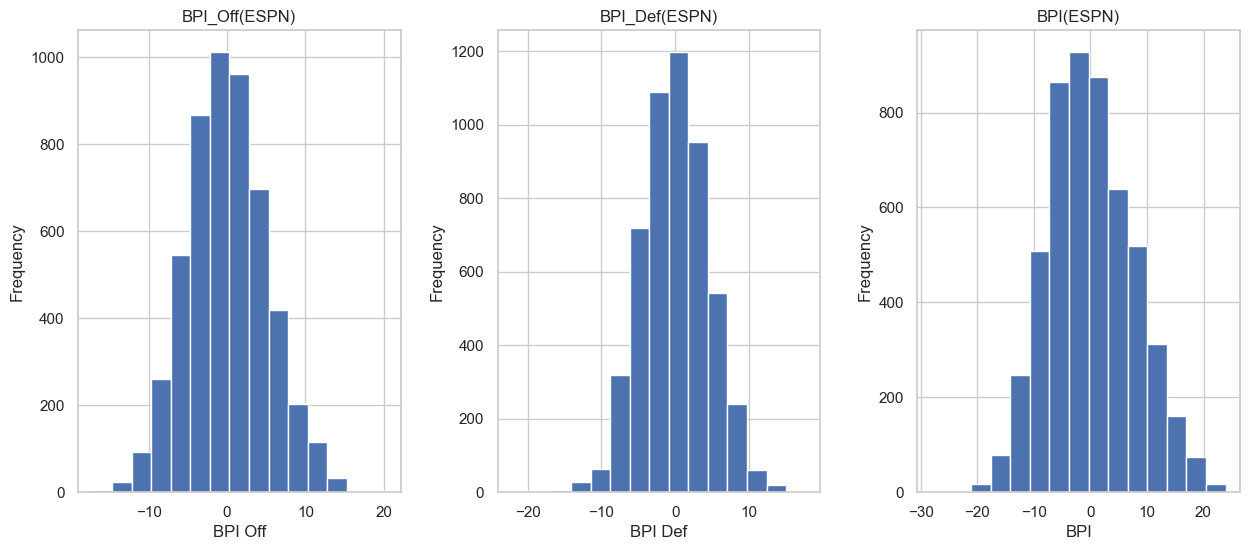

In [96]:
espn_bpi_df[['BPI_Off(ESPN)', 'BPI_Def(ESPN)', 'BPI(ESPN)']].hist(bins=15, figsize=(15, 6), layout=(1, 3))

# Formatting
plt.subplot(1, 3, 1)
plt.xlabel('BPI Off')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.xlabel('BPI Def')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.xlabel('BPI')
plt.ylabel('Frequency')
plt.show()

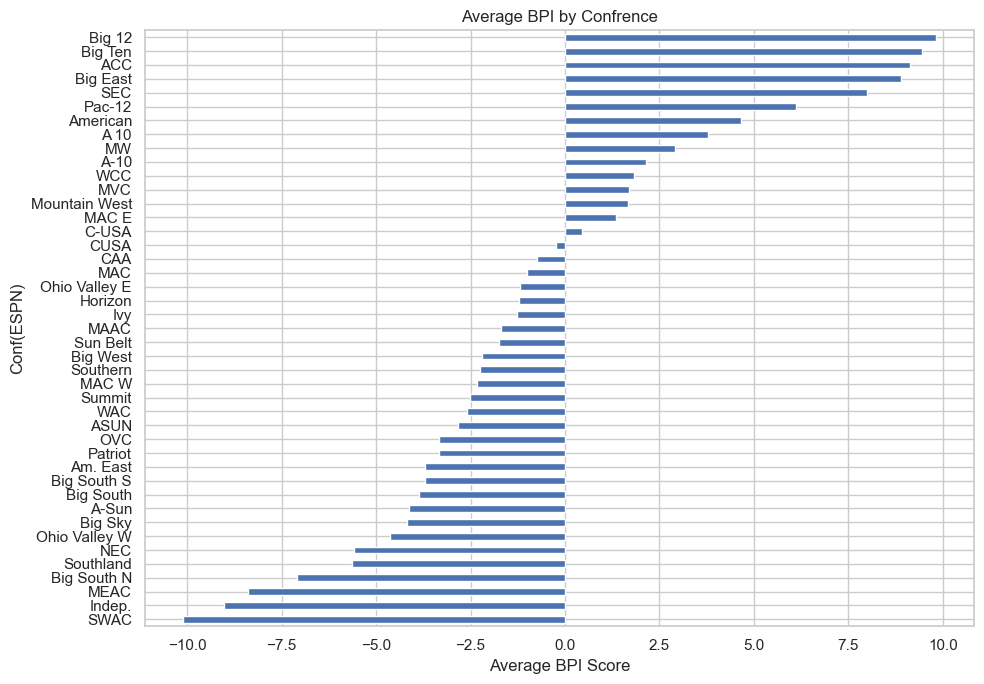

In [97]:
# Graph BPI by confrence

plt.figure(figsize=(10, 7))

# Plot the data
espn_bpi_df.groupby('Conf(ESPN)')['BPI(ESPN)'].mean().sort_values().plot(kind='barh')

# Formatting
plt.xlabel('Average BPI Score')
plt.title('Average BPI by Confrence')
plt.tight_layout()

plt.show()

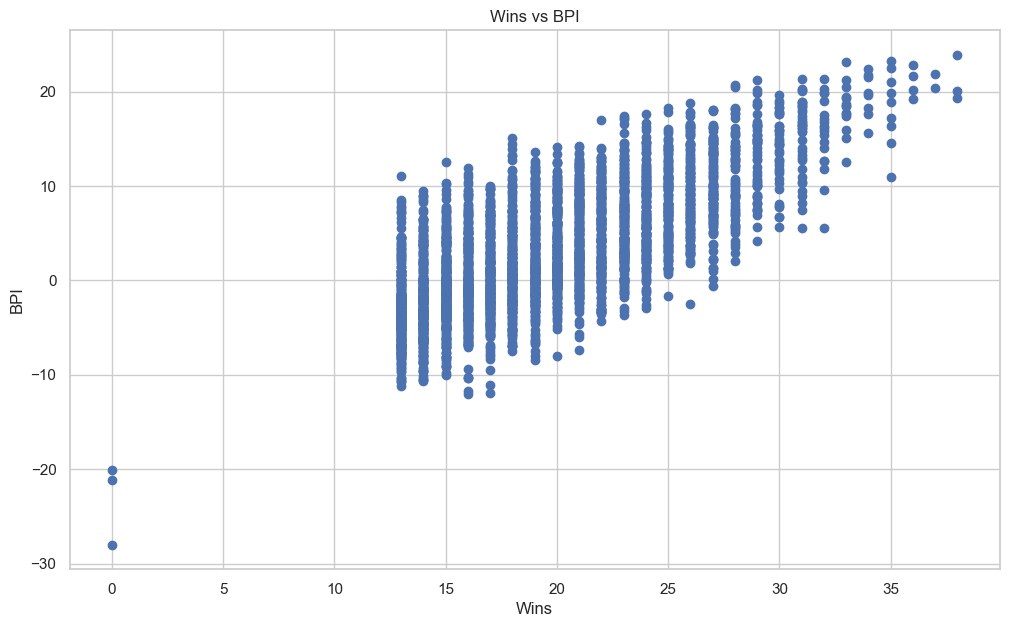

In [98]:
# Plot number of wins vs BPI

# Get individual Wins and Losses columns
espn_bpi_df[['Wins', 'Losses']] = espn_bpi_df['W-L(ESPN)'].str.split('-', expand=True)
espn_bpi_df['Wins'] = pd.to_numeric(espn_bpi_df['Wins'], errors='coerce')
espn_bpi_df['Losses'] = pd.to_numeric(espn_bpi_df['Losses'], errors='coerce')

# Check if there were any coercions to NaN, drop if so
espn_bpi_df.dropna(subset=['Wins', 'Losses'], inplace=True)

# Plot 
plt.figure(figsize=(12, 7))
plt.scatter(espn_bpi_df['Wins'], espn_bpi_df['BPI(ESPN)'])
plt.xlabel('Wins')
plt.ylabel('BPI')
plt.title('Wins vs BPI')
plt.show()

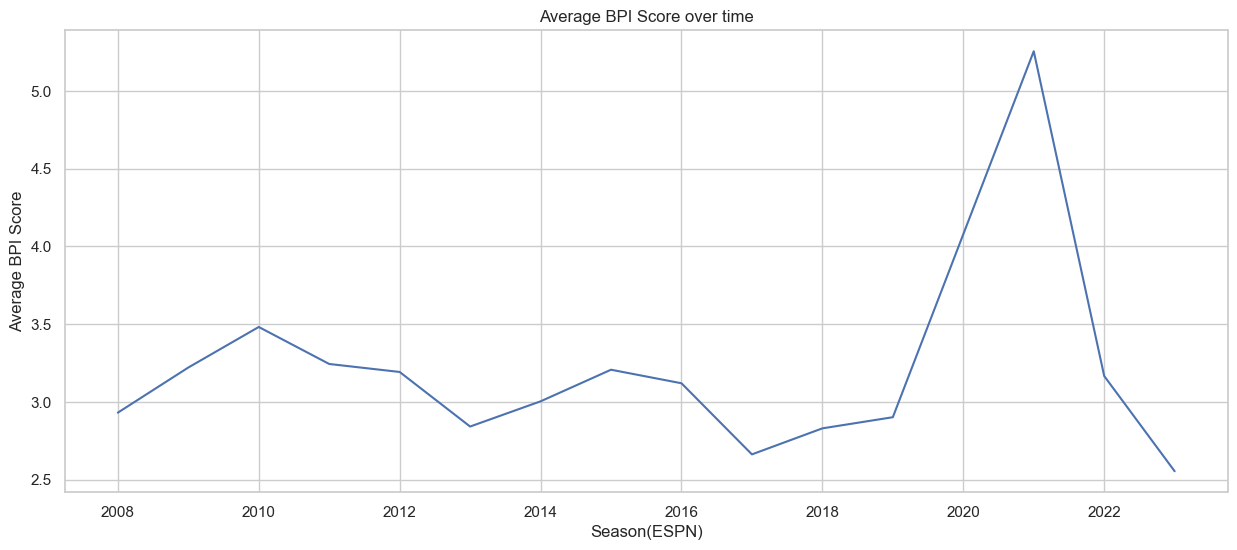

In [99]:
# Graph average BPI by year to see overall changes in BPI Ratings

espn_bpi_df.groupby('Season(ESPN)')['BPI(ESPN)'].mean().plot(kind='line', figsize=(15, 6))
plt.ylabel('Average BPI Score')
plt.title('Average BPI Score over time')
plt.show()

# 247 Player Rankings

In [100]:
playerRating_df = pd.DataFrame()

# Loop through each year, read the CSV, add a 'Year' column, and append to the main DataFrame
for year in range(2011, 2025):
    file_name = f'recruits_{year}.csv'
    if os.path.exists(file_name):  # Check if the file exists
        df = pd.read_csv(file_name)
        df['Year'] = year  # Add a column for the year
        playerRating_df = pd.concat([playerRating_df, df], ignore_index=True)

# Save the combined data to a new CSV file
playerRating_df.to_csv('combined_recruits.csv', index=False)

# If you want to see the DataFrame
playerRating_df

,Rank,Player,High School,Position,Height / Weight,Rating,Year
0,1,Anthony Davis,NaN,PF,6-10 / 220,100,2011
1,2,Michael Kidd-Gilchrist,NaN,SF,6-6 / 190,100,2011
2,3,Austin Rivers,NaN,PG,6-3 / 175,100,2011
3,4,Bradley Beal,NaN,SG,6-4 / 195,100,2011
4,5,Quincy Miller,NaN,PF,6-8 / 193,100,2011
...,...,...,...,...,...,...,...
2925,146,Chris McDermott,NaN,PF,6-7 / 215,88,2024
2926,147,Luke Bamgboye,NaN,C,6-10 / 190,88,2024
2927,148,Zion Pipkin,NaN,CG,6-1 / 175,88,2024
2928,149,Felix Kossaras,NaN,SG,6-5 / 180,88,2024


In [101]:
def rating_to_stars(rating):
    if 100 >= rating >= 98:
        return 5
    elif 97 >= rating >= 94:
        return 4
    elif 93 >= rating >= 0:
        return 3
    else:
        return None  # or some default value for ratings outside the specified ranges

# Apply the function to the 'Rating' column to create the 'Star' column
playerRating_df['Stars'] = playerRating_df['Rating'].apply(rating_to_stars)

# Now you can check the first few rows of your DataFrame
playerRating_df.head()


,Rank,Player,High School,Position,Height / Weight,Rating,Year,Stars
0,1,Anthony Davis,NaN,PF,6-10 / 220,100,2011,5
1,2,Michael Kidd-Gilchrist,NaN,SF,6-6 / 190,100,2011,5
2,3,Austin Rivers,NaN,PG,6-3 / 175,100,2011,5
3,4,Bradley Beal,NaN,SG,6-4 / 195,100,2011,5
4,5,Quincy Miller,NaN,PF,6-8 / 193,100,2011,5


In [102]:
playerRating_df.head()
playerRating_df.info()
playerRating_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rank             2930 non-null   object 
 1   Player           2930 non-null   object 
 2   High School      0 non-null      float64
 3   Position         2930 non-null   object 
 4   Height / Weight  2930 non-null   object 
 5   Rating           2930 non-null   int64  
 6   Year             2930 non-null   int64  
 7   Stars            2930 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 183.3+ KB


,High School,Rating,Year,Stars
count,0.0,2930.000000,2930.000000,2930.000000
mean,NaN,91.484300,2016.837543,3.465188
std,NaN,5.186181,3.820605,0.708662
min,NaN,10.000000,2011.000000,3.000000
25%,NaN,89.000000,2014.000000,3.000000
50%,NaN,91.000000,2017.000000,3.000000
75%,NaN,95.000000,2020.000000,4.000000
max,NaN,100.000000,2024.000000,5.000000


In [103]:
top_players = playerRating_df.groupby('Year')['Rating'].min()
print(top_players)

Year
2011    70
2012    10
2013    83
2014    87
2015    87
2016    10
2017    87
2018    88
2019    88
2020    90
2021    89
2022    89
2023    88
2024    88
Name: Rating, dtype: int64


In [104]:
def adjust_rating(row):
    if row['Rating'] == 10:
        return 101
    elif row['Player'] == 'Josh Jackson':
        return 102
    else:
        return row['Rating']

# Apply the function to each row
playerRating_df['Rating'] = playerRating_df.apply(adjust_rating, axis=1)

# Now you can check the first few rows of your DataFrame
playerRating_df.head()


,Rank,Player,High School,Position,Height / Weight,Rating,Year,Stars
0,1,Anthony Davis,NaN,PF,6-10 / 220,100,2011,5
1,2,Michael Kidd-Gilchrist,NaN,SF,6-6 / 190,100,2011,5
2,3,Austin Rivers,NaN,PG,6-3 / 175,100,2011,5
3,4,Bradley Beal,NaN,SG,6-4 / 195,100,2011,5
4,5,Quincy Miller,NaN,PF,6-8 / 193,100,2011,5


In [105]:
top_players = playerRating_df.groupby('Year')['Rating'].min()
top_players

Year
2011    70
2012    74
2013    83
2014    87
2015    87
2016    87
2017    87
2018    88
2019    88
2020    90
2021    89
2022    89
2023    88
2024    88
Name: Rating, dtype: int64

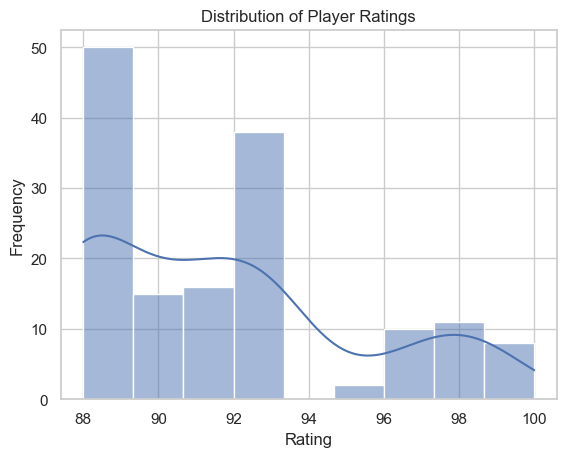

In [106]:
sns.histplot(df['Rating'], kde=True)
plt.title('Distribution of Player Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

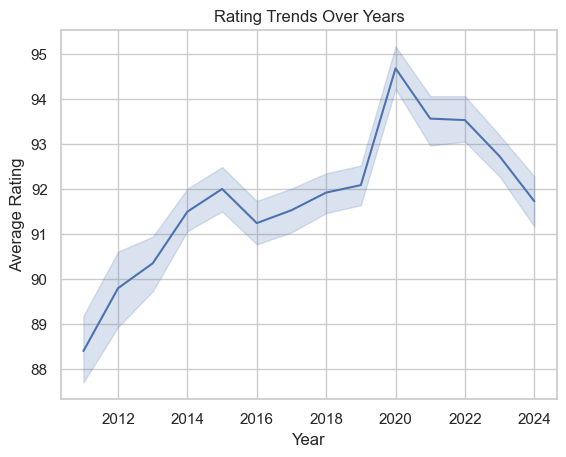

In [107]:
sns.lineplot(data=playerRating_df, x='Year', y='Rating')
plt.title('Rating Trends Over Years')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.show()

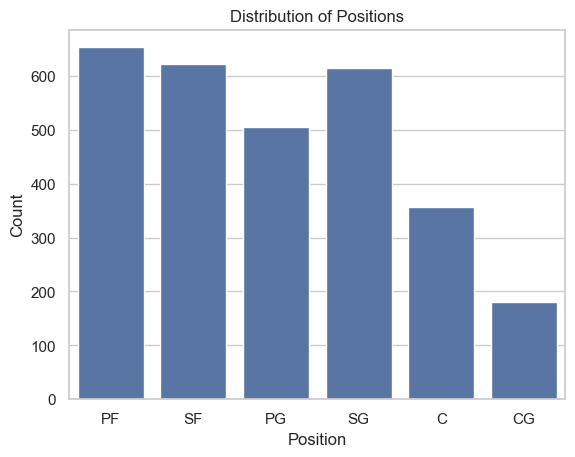

In [108]:
sns.countplot(x='Position', data=playerRating_df)
plt.title('Distribution of Positions')
plt.xlabel('Position')
plt.ylabel('Count')
plt.show()

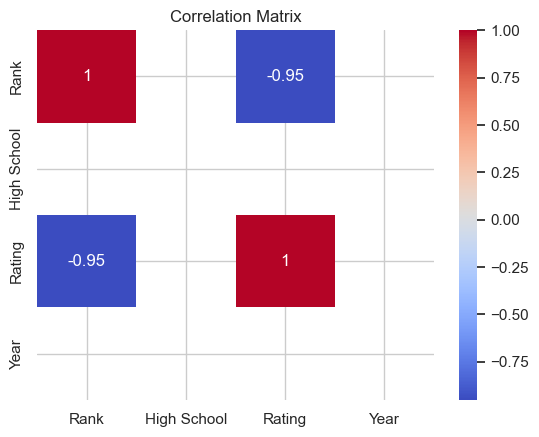

In [109]:
numeric_df = df.select_dtypes(include=[np.number])  # Select only numeric columns
correlation_matrix = numeric_df.corr()  # Compute the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Creating the Mother of All Dataframes 

All DataFrames:

combined_df - Kaggle Data (2003 - 2023)

espn_bpi_df - espn team ratings (2008 - 2023)

pomeroy_df - Ken Pomeroy rankings (2011-2023)

playerRating_df - 247 Player Data (2011 - 2023)

Now, we will combine the datasets into one main dataframe that we can eventually use for our official model.

In [110]:
combined_df

,TeamName,Season,Outcome,TeamID,DayNum,NumOT,Score,SCOREDIFF,FGM,FGA,...,FTPCT,OR,DR,ORBCHANCE,ORPCT,Ast,Stl,Blk,TO,PF
0,UNC Asheville,2003,1,1421,134,1,92,8,32,69,...,0.653846,14,30,42,0.333333,17,5,3,12,22
1,Arizona,2003,1,1112,136,0,80,29,31,66,...,0.785714,11,36,37,0.297297,22,10,7,16,8
2,Arizona St,2003,1,1113,136,0,84,13,31,59,...,0.727273,10,27,32,0.312500,18,7,4,9,19
3,C Michigan,2003,1,1141,136,0,79,6,29,53,...,0.720000,11,20,28,0.392857,15,13,1,18,19
4,California,2003,1,1143,136,1,76,2,27,64,...,0.652174,18,20,44,0.409091,17,8,2,13,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2357,USC,2021,0,1425,148,0,66,19,24,62,...,0.736842,7,20,34,0.205882,9,7,0,9,13
2358,Michigan,2021,0,1276,148,0,49,2,20,51,...,0.545455,8,24,29,0.275862,12,5,3,14,11
2359,Houston,2021,0,1222,152,0,59,19,21,55,...,0.687500,13,12,30,0.433333,10,4,5,10,10
2360,UCLA,2021,0,1417,152,1,90,3,34,59,...,0.666667,7,24,26,0.269231,21,4,1,9,16


In [111]:
pomeroy_df

,Season,TeamName,adj_o,adj_d,adj_tempo,luck,sos_adj_o,sos_adj_d
0,2011,Ohio St.,125.4,88.4,66.0,0.043,107.4,98.3
1,2011,Duke,118.8,87.2,70.1,0.006,106.0,97.4
2,2011,Kansas,119.8,88.3,69.6,0.071,106.1,98.7
3,2011,Texas,114.0,85.3,67.2,-0.055,105.6,97.8
4,2011,Purdue,116.1,87.2,67.1,-0.004,108.1,97.3
...,...,...,...,...,...,...,...,...
4218,2023,Florida A&M;,89.0,110.7,64.1,-0.013,103.0,105.2
4219,2023,IUPUI,93.1,117.9,66.9,-0.079,102.1,108.0
4220,2023,Green Bay,90.6,116.6,65.1,0.031,104.4,106.9
4221,2023,LIU,85.7,114.3,72.0,-0.027,101.2,108.6


In [112]:
combined_df['Season'] = combined_df['Season'].astype(int)
combined_df.dtypes

TeamName      object
Season         int64
Outcome        int64
TeamID         int64
DayNum         int64
NumOT          int64
Score          int64
SCOREDIFF      int64
FGM            int64
FGA            int64
FGPCT        float64
FGM3           int64
FGA3           int64
3PCT         float64
FTM            int64
FTA            int64
FTPCT        float64
OR             int64
DR             int64
ORBCHANCE      int64
ORPCT        float64
Ast            int64
Stl            int64
Blk            int64
TO             int64
PF             int64
dtype: object

In [113]:
pomeroy_df['Season'] = pomeroy_df['Season'].astype(int)
pomeroy_df.dtypes

Season         int64
TeamName      object
adj_o        float64
adj_d        float64
adj_tempo    float64
luck         float64
sos_adj_o    float64
sos_adj_d    float64
dtype: object

Because of some team name discrepancies between dataset, we used fuzzywuzzy to easily fuzzy match team names.

In [114]:
def fuzzy_match(team_name, choices):
    match, score = process.extractOne(team_name, choices)
    if score >= 90:
        return match
    else:
        return None

# create best match column
combined_df['BestMatch'] = combined_df['TeamName'].apply(lambda row: fuzzy_match(row, pomeroy_df['TeamName'].unique()))

# merge using the fuzzy match column
mother_df = pd.merge(combined_df, pomeroy_df, left_on=['BestMatch', 'Season'], right_on=['TeamName', 'Season'], how='inner')

# remove the column containg fuzzy match after we merge
mother_df.drop('BestMatch', axis=1, inplace=True)

mother_df

,TeamName_x,Season,Outcome,TeamID,DayNum,NumOT,Score,SCOREDIFF,FGM,FGA,...,Blk,TO,PF,TeamName_y,adj_o,adj_d,adj_tempo,luck,sos_adj_o,sos_adj_d
0,Clemson,2011,1,1155,134,0,70,18,26,50,...,2,12,12,Clemson,106.5,88.7,65.0,-0.074,104.3,98.3
1,Clemson,2011,0,1155,136,0,76,8,25,58,...,3,9,24,Clemson,106.5,88.7,65.0,-0.074,104.3,98.3
2,Butler,2011,1,1139,136,0,60,2,22,54,...,1,15,21,Butler,111.8,96.7,64.4,-0.005,103.3,99.4
3,Butler,2011,1,1139,138,0,71,1,24,52,...,2,6,18,Butler,111.8,96.7,64.4,-0.005,103.3,99.4
4,Butler,2011,1,1139,143,0,61,7,19,45,...,2,14,19,Butler,111.8,96.7,64.4,-0.005,103.3,99.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232,St Bonaventure,2021,0,1382,138,0,61,15,21,63,...,5,3,17,St. Bonaventure,112.0,89.8,65.2,0.014,105.8,97.6
1233,Connecticut,2021,0,1163,138,0,54,9,21,65,...,5,10,17,Connecticut,114.3,90.9,66.0,-0.066,107.9,95.3
1234,Virginia,2021,0,1438,138,0,58,4,21,60,...,7,3,13,Virginia,116.3,92.3,60.1,0.046,109.6,97.6
1235,Missouri,2021,0,1281,138,0,68,4,22,58,...,4,8,18,Missouri,110.9,94.4,68.7,0.088,109.8,94.7


In [115]:
# Check for nan values...

nan_counts = mother_df.isna().sum()
print(nan_counts)

TeamName_x    0
Season        0
Outcome       0
TeamID        0
DayNum        0
NumOT         0
Score         0
SCOREDIFF     0
FGM           0
FGA           0
FGPCT         0
FGM3          0
FGA3          0
3PCT          0
FTM           0
FTA           0
FTPCT         0
OR            0
DR            0
ORBCHANCE     0
ORPCT         0
Ast           0
Stl           0
Blk           0
TO            0
PF            0
TeamName_y    0
adj_o         0
adj_d         0
adj_tempo     0
luck          0
sos_adj_o     0
sos_adj_d     0
dtype: int64


# Pipeline


This pipeline automates the evaluation of machine learning models on basketball game data across various seasons. 

Key features include:
- Season-wise Data Processing: Analyzes data for each season separately, catering to year-specific trends.
- Flexible Feature Selection: Allows easy customization of input features for analysis.
- Multiple Model Evaluation: Tests different models (like Logistic Regression, XGBoost, and Linear Regression) and compares their performances.
- Data Standardization: Scales features to ensure fair model comparison.
- Robustness Checks: Identifies and handles missing data for each season.
- Performance Metrics: Calculates key metrics to assess each model's accuracy and effectiveness.
- Result Visualization: Provides graphical representations for easier interpretation of model performances.

  
This pipeline is designed for efficiently processing new data and quickly assessing the impact of different features on model predictions.

In [116]:
# training functions for logistic regression and XGBoost
def train_logistic_regression(X_train, y_train):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    return model

def train_xgboost(X_train, y_train):
    model = XGBClassifier()
    model.fit(X_train, y_train)
    return model

# function to train and evaluate models
def train_and_evaluate_model(model_fn, X_train, y_train, X_test, y_test):
    model = model_fn(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    brier = brier_score_loss(y_test, y_proba)

    return accuracy, precision, recall, f1, roc_auc, brier

# create pipeline function
def run_pipeline_for_season(season, features, mother_df):
    season_data = mother_df[mother_df['Season'] == season]
    
    if season_data.empty:
        print(f"No data available for season {season}. Skipping...")
        return None
    
    X = season_data[features]
    y = (season_data['Outcome'] > 0.5).astype(int)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    results = []

    # classification models
    for model_name, model_fn in [('Logistic Regression', train_logistic_regression),
                                 ('XGBoost', train_xgboost)]:
        accuracy, precision, recall, f1, roc_auc, brier = train_and_evaluate_model(model_fn, X_train_scaled, y_train, X_test_scaled, y_test)
        results.append({
            'Season': season, 
            'Model': model_name, 
            'Accuracy': accuracy, 
            'Precision': precision, 
            'Recall': recall, 
            'F1 Score': f1, 
            'ROC AUC': roc_auc, 
            'Brier Score': brier
        })
    # linear regression model
    linear_model = LinearRegression()
    linear_model.fit(X_train_scaled, y_train)
    y_pred = linear_model.predict(X_test_scaled)

    # force predictions to [0, 1] using the sigmoid function
    y_pred_squashed = expit(y_pred)

    # calculate the Brier score for the squashed predictions
    linear_brier = brier_score_loss(y_test, y_pred_squashed)

    results.append({
        'Season': season, 
        'Model': 'Linear Regression', 
        'Brier Score': linear_brier, 
        'MAE': mean_absolute_error(y_test, y_pred), 
        'MSE': mean_squared_error(y_test, y_pred)
    })

    
    return results

# hold results for each season
all_season_results = []

# iterate through each season
for season in range(2003, 2022):
    features = ['SCOREDIFF', 'Score', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF', 'FGPCT', '3PCT', 'FTPCT', 'ORBCHANCE', 'ORPCT', 'adj_o', 'adj_d', 'adj_tempo', 'luck', 'sos_adj_o', 'sos_adj_d']
    season_results = run_pipeline_for_season(season, features, mother_df)
    
    if season_results:
        all_season_results.extend(season_results)

results_df = pd.DataFrame(all_season_results)

No data available for season 2003. Skipping...
No data available for season 2004. Skipping...
No data available for season 2005. Skipping...
No data available for season 2006. Skipping...
No data available for season 2007. Skipping...
No data available for season 2008. Skipping...
No data available for season 2009. Skipping...
No data available for season 2010. Skipping...
No data available for season 2020. Skipping...


We are not concerned about data before 2010 as it will not provide much insight on the current tournament. 2020 data is incomeplete we believe due to Covid19 difficulties.

In [117]:
linear_df = results_df[results_df['Model'] == 'Linear Regression']
classification_df = results_df[results_df['Model'] != 'Linear Regression']
logistic_df = results_df[results_df['Model'] == 'Logistic Regression']
xgBoost_df = results_df[results_df['Model'] == 'XGBoost']

We will analyze the results of our model below:

# All Models Analysis 

### Brier Score:
A scoring method used to assess the accuracy of probabilistic forecasts in binary or multi-class classification problems.
Measures the mean squared difference between predicted probabilities and actual outcomes.
Commonly used in weather forecasting, sports predictions, and other areas where probabilistic forecasts are made.
Lower Brier Scores indicate better-calibrated predictions.

### Brier Score Formula:
For binary classification:

$$
\begin{equation}
\text{Brier Score} = \frac{1}{n} \sum_{i=1}^{n} (y_i - P_i)^2
\end{equation}
$$

where:
- n is the number of instances or observations.
- y is the actual binary outcome (0 or 1).
- P is the predicted probability of the positive class (usually between 0 and 1).

For example:

- If the forecast is $100% (P = 1)$ and it rains, then the Brier Score is 0, the best score achievable.
- If the forecast is $100%$ and it does not rain, then the Brier Score is 1, the worst score achievable.
- If the forecast is $70% (P = 0.70)$ and it rains, then the Brier Score is $(0.70−1)^{2}$ = $0.09$.
- In contrast, if the forecast is $70% (P = 0.70)$ and it does not rain, then the Brier Score is $(0.70−0)^{2}$ = $0.49$.
- Similarly, if the forecast is $30% (P = 0.30)$ and it rains, then the Brier Score is $(0.30−1)^{2}$ = 0.49.
- If the forecast is $50% (P = 0.50)$, then the Brier score is $(0.50−1)^{2} = (0.50−0)^{2} = 0.25$, regardless of whether it rains.

### Interpretation:
A perfect Brier Score is 0, indicating perfect calibration.
Higher scores represent worse calibration and indicate the model's predicted probabilities are further from the actual outcomes.
It provides a measure of the overall accuracy and reliability of probabilistic forecasts.

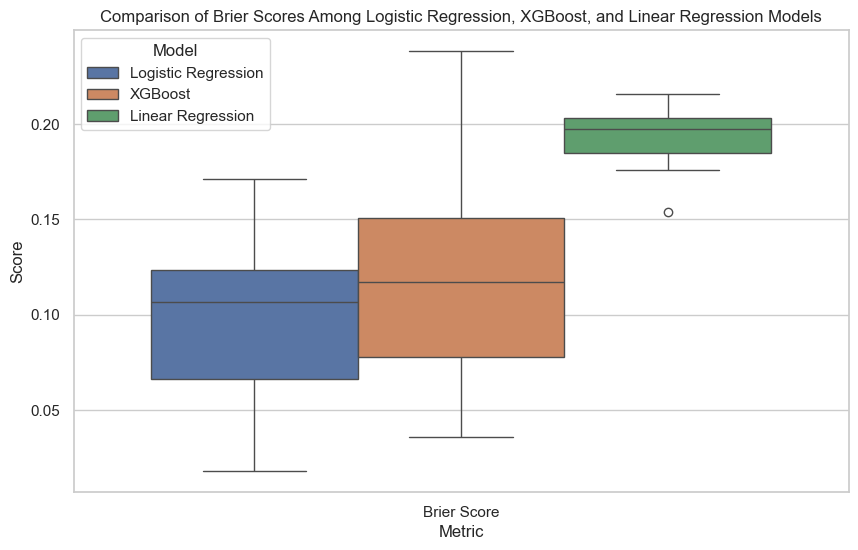

In [118]:
# compare Brier Score across 3 models
brier_score_column_name = 'Brier Score'  

# melt the dataframes
log_reg_melted = logistic_df.melt(id_vars=['Season'], value_vars=[brier_score_column_name], 
                                       var_name='Metric', value_name='Score')

log_reg_melted['Model'] = 'Logistic Regression'

xgb_melted = xgBoost_df.melt(id_vars=['Season'], value_vars=[brier_score_column_name], 
                               var_name='Metric', value_name='Score')
xgb_melted['Model'] = 'XGBoost'

lin_reg_melted = linear_df.melt(id_vars=['Season'], value_vars=[brier_score_column_name], 
                                       var_name='Metric', value_name='Score')

lin_reg_melted['Model'] = 'Linear Regression'

# combine all the melted dataframes
combined_melted = pd.concat([log_reg_melted, xgb_melted, lin_reg_melted])

plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Score', hue='Model', data=combined_melted)
plt.title('Comparison of Brier Scores Among Logistic Regression, XGBoost, and Linear Regression Models')
plt.show()

Here we can see that our logisitic regression model still seems to be outperforming our XGBoost model, which is not what we expected. We were not yet able to incorporate all of the data we wanted into our model, but both the logisitc regression and XGBoost models have median scores near the competitive scores from the previous years competition. In 2023, the winning Brier Score was 0.17371, followed by many submissions with extremely similar scores.

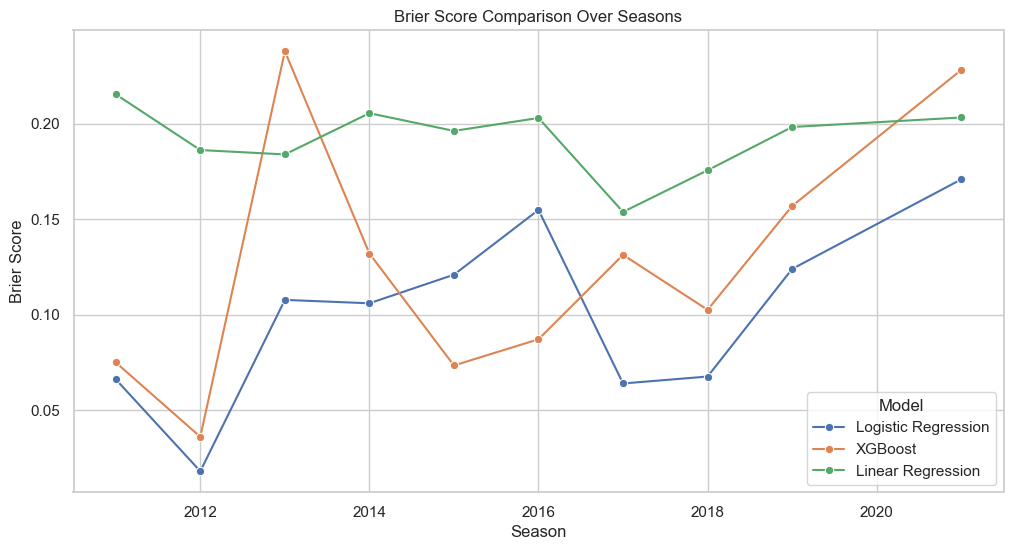

In [119]:
# Brier Score for all models across seasons
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='Season', y='Brier Score', hue='Model', marker='o')
plt.title('Brier Score Comparison Over Seasons')
plt.ylabel('Brier Score')
plt.show()

# Linear Regression Results

### Mean Absolute Error (MAE):
- Measures the average absolute difference between the predicted and actual values in a regression problem.
- Provides a straightforward and easily interpretable measure of error.
- Less sensitive to outliers compared to MSE.
- Formula, where n is the number of data points:
$$
\begin{equation}
\frac{1}{n} \sum_{i=1}^{n} \lvert actual_i - predicted_i \rvert
\end{equation}
$$

### Mean Squared Error (MSE):
- Measures the average of the squared differences between predicted and actual values in a regression problem.
- Puts more weight on large errors, making it sensitive to outliers.
- Often used in optimization and training machine learning models.
- Formula, where n is the number of data points:
$$
\begin{equation}
\frac{1}{n} \sum_{i=1}^{n} (actual_i - predicted_i)^2
\end{equation}
$$ 

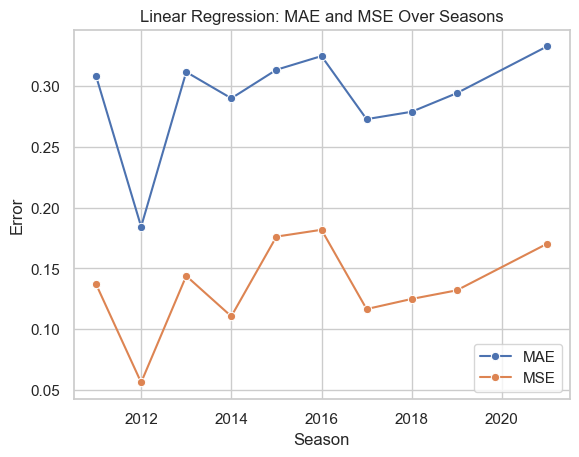

In [120]:
# Plotting MAE and MSE for Linear Regression
sns.lineplot(data=linear_df, x='Season', y='MAE', marker='o', label='MAE')
sns.lineplot(data=linear_df, x='Season', y='MSE', marker='o', label='MSE')
plt.title('Linear Regression: MAE and MSE Over Seasons')
plt.ylabel('Error')
plt.legend()
plt.show()

# Classification Results

### Accuracy:
- Measures the overall correctness of a classification model.
- Calculates the ratio of correctly predicted instances to the total instances.
- Formula: 
$$
\begin{equation}
\frac{{\text{True Positives} + \text{True Negatives}}}{{\text{Total Predictions}}}
\end{equation}
$$

### Precision:
- Measures the proportion of true positive predictions among all positive predictions made by the model.
- Focuses on minimizing false positives.
- Formula: 
$$
\frac{{\text{True Positives}}}{{\text{True Positives + False Positives}}}
$$  

### Recall (Sensitivity or True Positive Rate):
- Measures the proportion of true positive predictions among all actual positive instances.
- Focuses on minimizing false negatives.
- Formula: 
$$
\frac{{\text{True Positives}}}{{\text{True Positives + False Negatives}}}
$$   


### F1 Score:
- Harmonic mean of Precision and Recall.
- Useful when there is an imbalance between positive and negative classes.
- Balances the trade-off between Precision and Recall.
- Formula:
$$
F_1 \text{ Score: } 2 \times \frac{{\text{Precision} \times \text{Recall}}}{{\text{Precision + Recall}}}
$$
   


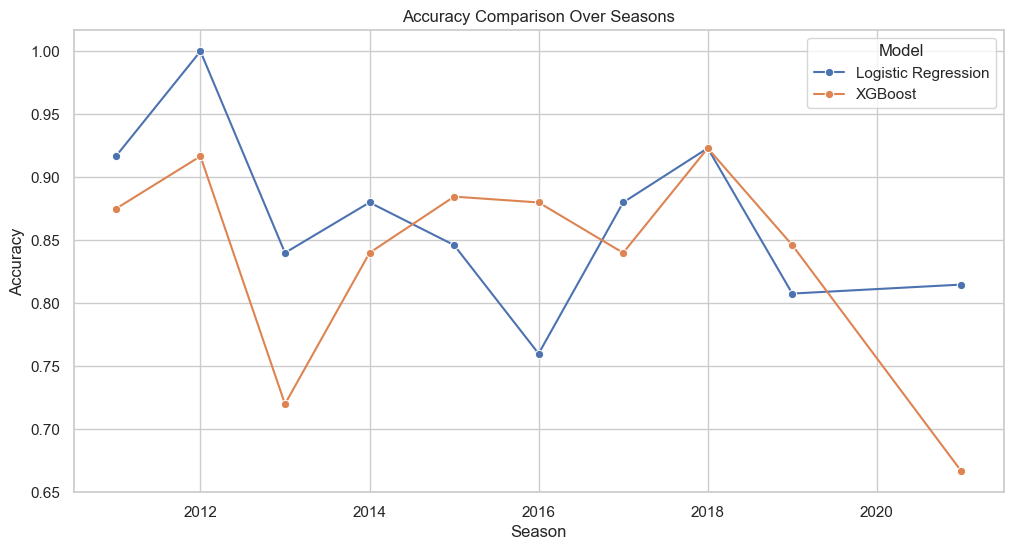

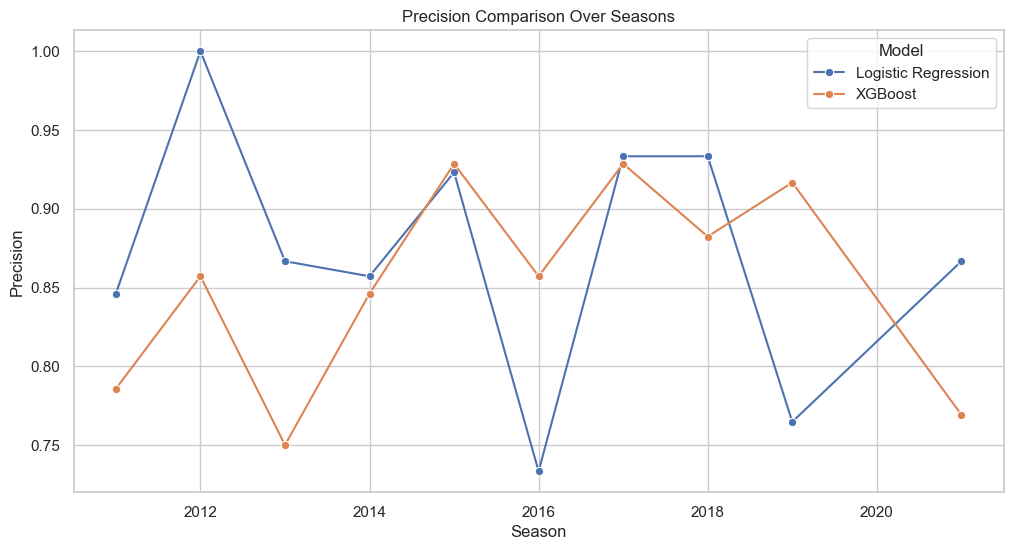

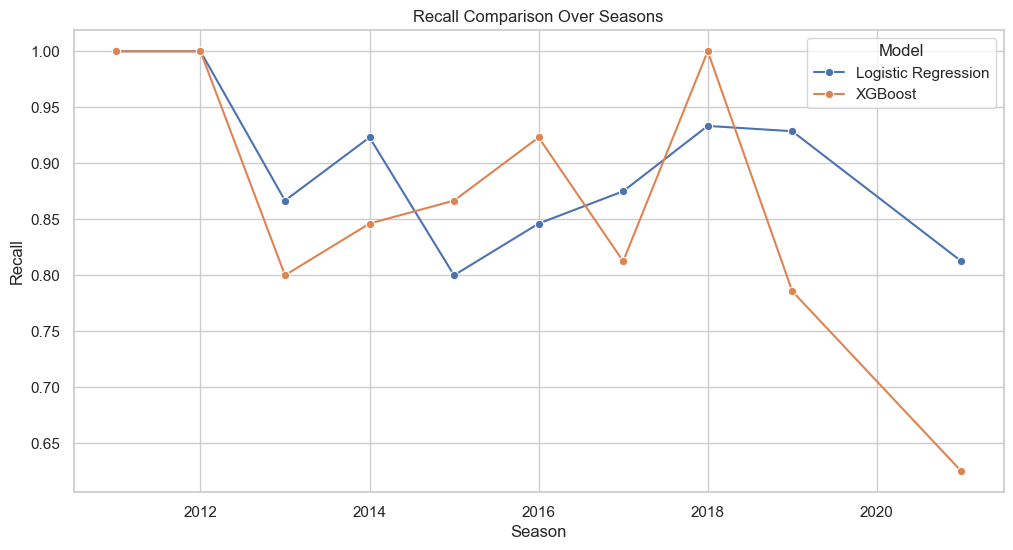

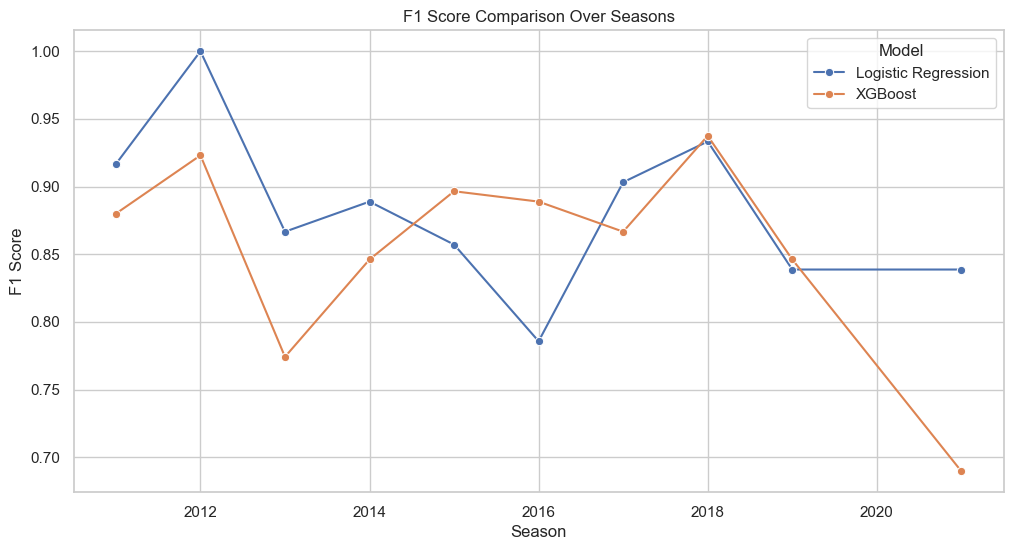

In [121]:
# plot Accuracy, Precision, Recall, and F1 Score for Classification Models
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
for metric in metrics:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=classification_df, x='Season', y=metric, hue='Model', marker='o')
    plt.title(f'{metric} Comparison Over Seasons')
    plt.ylabel(metric)
    plt.show()

Based on these metrics, Logisitic Regression yet again outperforms XGBoost on every metric in the most recent year. This could indicate improper use of our XGBoost model, we should perhaps consider using more seasons to train the models on as we are currently using one previous season to predict the next season.

# Logistic Regression Analysis

Below we look at the metrics above for only the Logistic Regression model as well as ROC AUC and Brier score, over each season.

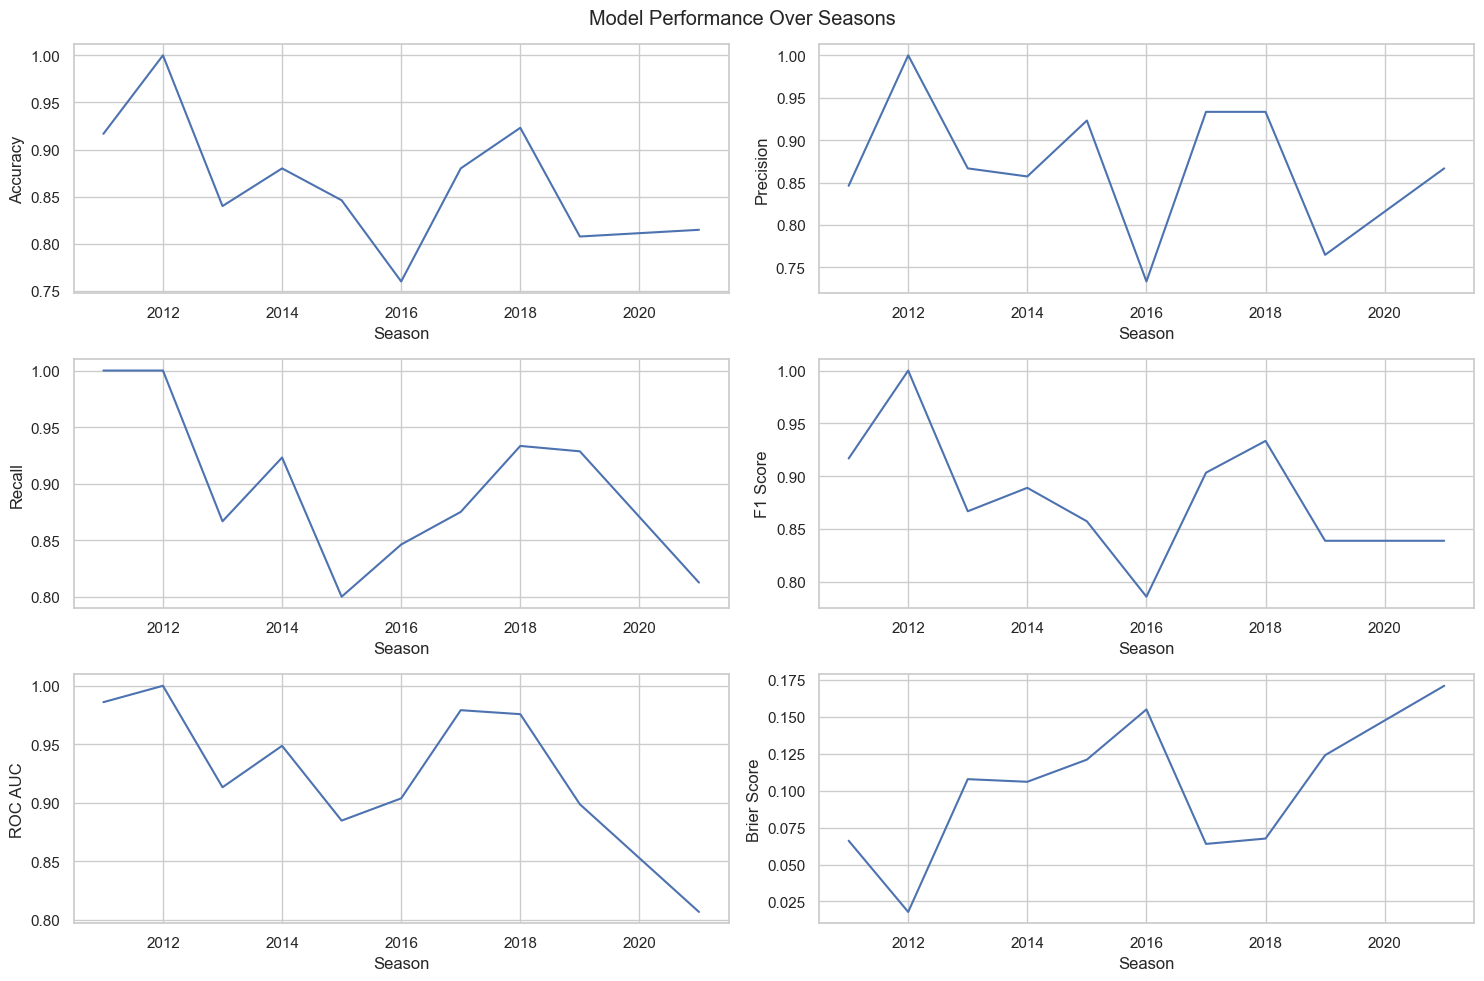

In [122]:
sns.set(style="whitegrid")

# formatting
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('Model Performance Over Seasons')

sns.lineplot(x='Season', y='Accuracy', data=logistic_df, ax=axes[0, 0])
sns.lineplot(x='Season', y='Precision', data=logistic_df, ax=axes[0, 1])
sns.lineplot(x='Season', y='Recall', data=logistic_df, ax=axes[1, 0])
sns.lineplot(x='Season', y='F1 Score', data=logistic_df, ax=axes[1, 1])
sns.lineplot(x='Season', y='ROC AUC', data=logistic_df, ax=axes[2, 0])
sns.lineplot(x='Season', y='Brier Score', data=logistic_df, ax=axes[2, 1])

plt.tight_layout()
plt.show()

The most important takeaway here is that Brier Score has increased for our Logistic Regression model since 2018, despite the fact that F1 score has remained fairly constant and Precision has actually increased. 

# XG Boost Analysis 

Below we look at the metrics above for only the XGBoost model as well as ROC AUC and Brier score, over each season.

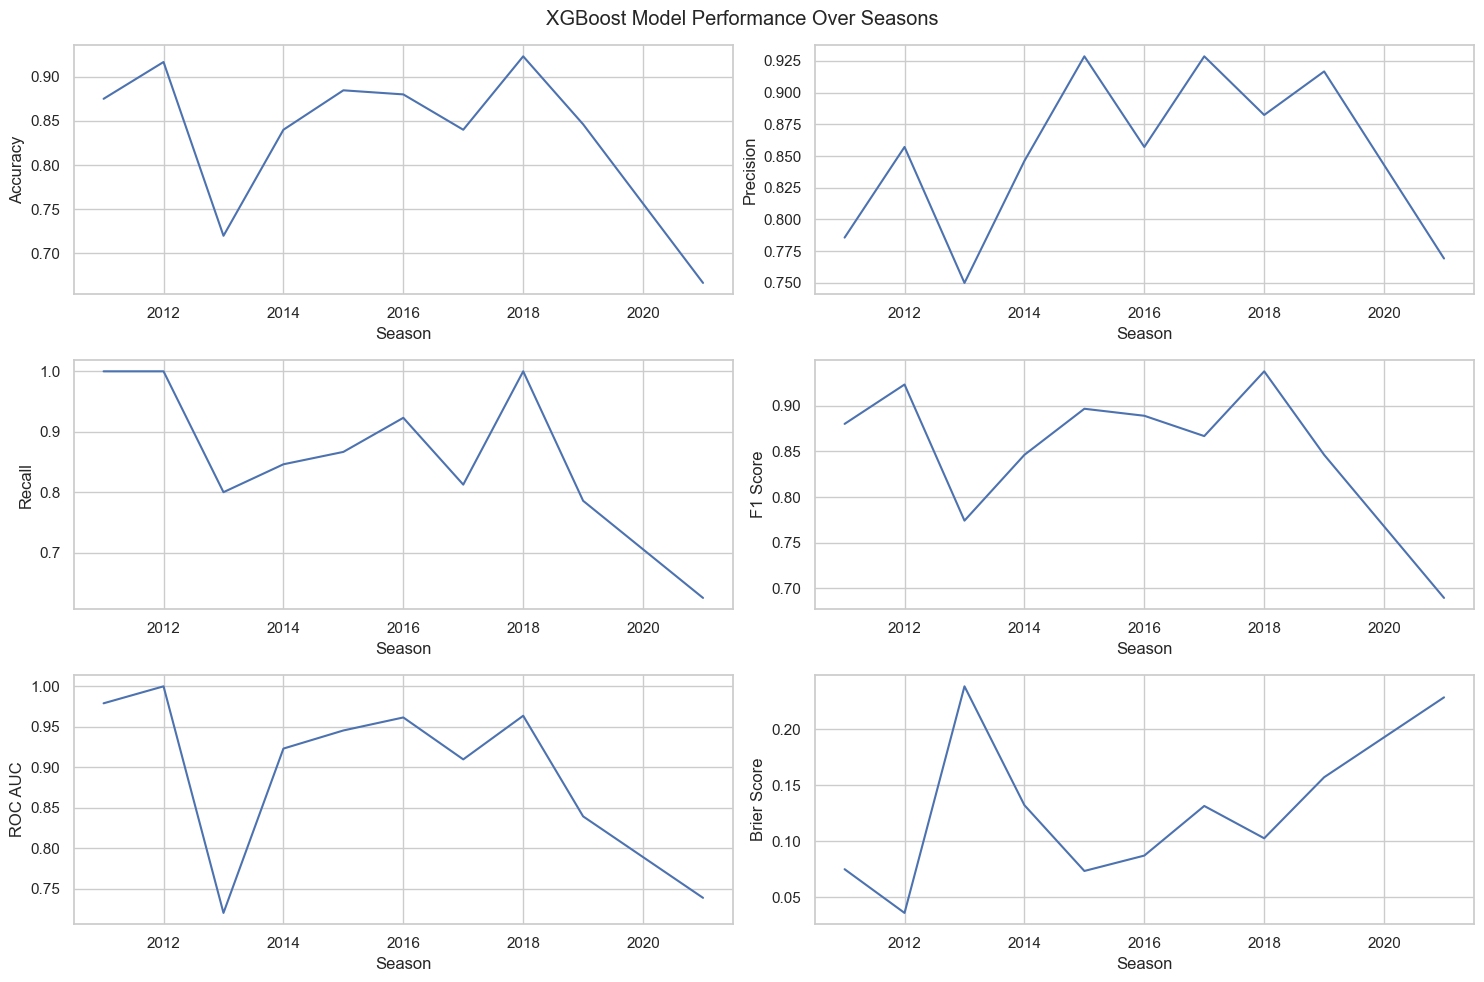

In [123]:
# formatting
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('XGBoost Model Performance Over Seasons')

sns.lineplot(x='Season', y='Accuracy', data=xgBoost_df, ax=axes[0, 0])
sns.lineplot(x='Season', y='Precision', data=xgBoost_df, ax=axes[0, 1])
sns.lineplot(x='Season', y='Recall', data=xgBoost_df, ax=axes[1, 0])
sns.lineplot(x='Season', y='F1 Score', data=xgBoost_df, ax=axes[1, 1])
sns.lineplot(x='Season', y='ROC AUC', data=xgBoost_df, ax=axes[2, 0])
sns.lineplot(x='Season', y='Brier Score', data=xgBoost_df, ax=axes[2, 1])


plt.tight_layout()
plt.show()

We see a similar trend in our XGBoost model as in our Logistic Regression of Brier Score increasing for recent years, this could indicate that features that have previous been effective at predicting game winners are changing or are becoming less effective. 

# Conclusion

It is important to realize that this project is not yet complete. We have additional datasets that we want to include in our models, but for the sake of clarity at this time, we have chose to include the KenPom dataset because it cleanly merges with our initial Kaggle dataframe. The additional datsets that will be included are:

- [247 Player Rankings data](https://247sports.com/Season/2023-Basketball/RecruitRankings/)

- [ESPN BPI rankings](https://www.espn.com/mens-college-basketball/bpi)

However, we have come a long way from our initial model. We had some initial issues with overfitting indicated by our 99% accuracy results. We have also experimented with external datasets that actually decreased our Brier Score as well. At this point, we have our pipeline setup to take in different models and features, which will allow us to easily experiment with more data we want to add as well as refine the features we choose to include.


In all, having achieved a median XGBoost model Brier Score between 0.10 and 0.15 and an even lower score in this range for our Logistic Regression model, we feel that we are in a strong position to compete for the prize and continue to improve our model.